# Default Probability Prediction

## Librerías


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
import seaborn as sns
import funcionesauxiliares as fa
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import dask.dataframe as dd


## Sobre los datos

Este ejercicio busca mejorar la predicción de impago de crédito (default), clave para gestionar el riesgo en préstamos al consumidor y optimizar las decisiones de los prestamistas. Aunque existen modelos actuales,
se pretende crear uno más eficiente mediante técnicas de machine learning y un conjunto de datos a escala industrial, que incluye datos de comportamiento y perfiles anonimizados de clientes. Si es exitoso, el modelo
mejorará la experiencia del cliente, facilitando la aprobación de tarjetas de crédito, y ofrecerá oportunidades de premios, entrevistas y posibles nuevas carreras.

El objetivo de este proyecto es predecir la probabilidad de que un cliente no pague el saldo de su tarjeta de crédito en el futuro, basado en su perfil mensual. La variable objetivo es binaria y se calcula observando
una ventana de rendimiento de 18 meses posterior a la última fecha de estado de cuenta. Si el cliente no paga el saldo adeudado dentro de los 120 días posteriores a su última fecha de estado de cuenta, se considera un
evento de impago (default). El conjunto de datos contiene características agregadas del perfil de cada cliente en cada fecha de estado de cuenta.


In [ ]:
train_data = pd.read_csv('train_data.csv')

In [4]:
train_labels = pd.read_csv('train_labels.csv')

In [5]:
train_data.shape

(5531451, 190)

In [6]:
train_labels.shape

(458913, 2)

`train_data` contiene 190 variables y 5531451 de registros, `train_labels` contiene solo dos variables y 458913 registros, estas variables representan una id de usuario y el valor de la variable objetivo. En `train_data` existen varios registros asociados a un mismo id de usuario. 

## Sobre las variables

Dentro de este dataset se pueden encontrar tres tipos de variables: categóricas, enteros y flotantes. En el caso de las variables *categóricas*, estás corresponden a: `customer_ID`, `S_2`, `D_63`, `D_64`. Las flotantes o decimales representan un 97,4% (185 variables) del dataset y por último, solo se encuentra una variable de tipo entero llamada `B_31`.

In [7]:
# Tipos de variables presentes en el dataset
train_data.dtypes.unique()

array([dtype('O'), dtype('float64'), dtype('int64')], dtype=object)

In [8]:
# solo variables de tipo objeto o categóricas
train_data.select_dtypes(include = 'object')

customer_ID         S_2 D_63  \
0        0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-03-09   CR   
1        0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-04-07   CR   
2        0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-05-28   CR   
3        0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-06-13   CR   
4        0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-07-16   CR   
...                                                    ...         ...  ...   
5531446  fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...  2017-11-05   CL   
5531447  fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...  2017-12-23   CL   
5531448  fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...  2018-01-06   CL   
5531449  fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...  2018-02-06   CL   
5531450  fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...  2018-03-14   CL   

        D_64  
0          O  
1          O  
2          O  
3          O  
4          O  
...      ...  
5531446    O  
5531447    O  
5531448    O  
5531449    O  
5531450    O  

[5531451 rows x 4 columns]

In [9]:
# Solo variables de tipo flotante
train_data.select_dtypes(include = 'float64')

P_2      D_39       B_1       B_2       R_1       S_3      D_41  \
0        0.938469  0.001733  0.008724  1.006838  0.009228  0.124035  0.008771   
1        0.936665  0.005775  0.004923  1.000653  0.006151  0.126750  0.000798   
2        0.954180  0.091505  0.021655  1.009672  0.006815  0.123977  0.007598   
3        0.960384  0.002455  0.013683  1.002700  0.001373  0.117169  0.000685   
4        0.947248  0.002483  0.015193  1.000727  0.007605  0.117325  0.004653   
...           ...       ...       ...       ...       ...       ...       ...   
5531446  0.979332  0.416013  0.020818  0.828199  0.003487  0.090743  0.005340   
5531447  0.984907  0.296536  0.007209  0.812610  0.005904  0.079886  0.002243   
5531448  0.983019  0.443984  0.013151  0.815422  0.003457  0.100503  0.002111   
5531449  0.969861  0.442553  0.009855  1.003541  0.005117  0.101802  0.009930   
5531450  0.982175  0.002474  0.000077  0.992880  0.000809  0.119165  0.003287   

              B_3  D_42      D_43  ...  D_136  D_137  D_138     D_139  \
0        0.004709   NaN       NaN  ...    NaN    NaN    NaN  0.002427   
1        0.002714   NaN       NaN  ...    NaN    NaN    NaN  0.003954   
2        0.009423   NaN       NaN  ...    NaN    NaN    NaN  0.003269   
3        0.005531   NaN       NaN  ...    NaN    NaN    NaN  0.006117   
4        0.009312   NaN       NaN  ...    NaN    NaN    NaN  0.003671   
...           ...   ...       ...  ...    ...    ...    ...       ...   
5531446  0.025139   NaN  0.014225  ...    NaN    NaN    NaN  0.006838   
5531447  0.023691   NaN  0.009467  ...    NaN    NaN    NaN  0.003310   
5531448  0.012343   NaN  0.006591  ...    NaN    NaN    NaN  0.009955   
5531449  0.008578   NaN  0.014235  ...    NaN    NaN    NaN  0.005541   
5531450  0.014092   NaN  0.013455  ...    NaN    NaN    NaN  0.007316   

            D_140     D_141  D_142     D_143     D_144     D_145  
0        0.003706  0.003818    NaN  0.000569  0.000610  0.002674  
1        0.003167  0.005032    NaN  0.009576  0.005492  0.009217  
2        0.007329  0.000427    NaN  0.003429  0.006986  0.002603  
3        0.004516  0.003200    NaN  0.008419  0.006527  0.009600  
4        0.004946  0.008889    NaN  0.001670  0.008126  0.009827  
...           ...       ...    ...       ...       ...       ...  
5531446  0.003680  0.000457    NaN  0.000905  0.001498  0.002774  
5531447  0.007097  0.007857    NaN  0.002777  0.008225  0.008856  
5531448  0.009994  0.001088    NaN  0.005693  0.006773  0.005566  
5531449  0.006564  0.009883    NaN  0.008123  0.001168  0.003983  
5531450  0.002888  0.006207    NaN  0.005110  0.003184  0.001914  

[5531451 rows x 185 columns]

In [10]:
# solo variables de tipo entero
train_data.select_dtypes(include = 'int64')

B_31
0           1
1           1
2           1
3           1
4           1
...       ...
5531446     1
5531447     1
5531448     1
5531449     1
5531450     1

[5531451 rows x 1 columns]

Sin embargo, se especificó que también ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68'] son categóricas.

In [6]:
temp = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68']

# Convertir ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68'] a categóricas
train_data[temp] = train_data[temp].astype(str)
train_data[temp] = train_data[temp].replace('nan', np.nan)

In [24]:
train_data.select_dtypes(include = 'object')

customer_ID         S_2 D_63  \
0        0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-03-09   CR   
1        0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-04-07   CR   
2        0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-05-28   CR   
3        0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-06-13   CR   
4        0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-07-16   CR   
...                                                    ...         ...  ...   
5531446  fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...  2017-11-05   CL   
5531447  fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...  2017-12-23   CL   
5531448  fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...  2018-01-06   CL   
5531449  fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...  2018-02-06   CL   
5531450  fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...  2018-03-14   CL   

        D_64 D_66 D_68 B_30 B_38 D_114 D_116 D_117 D_120 D_126  
0          O  NaN  6.0  0.0  2.0   1.0   0.0   4.0   0.0   1.0  
1          O  NaN  6.0  0.0  2.0   1.0   0.0   4.0   0.0   1.0  
2          O  NaN  6.0  0.0  2.0   1.0   0.0   4.0   0.0   1.0  
3          O  NaN  6.0  0.0  2.0   1.0   0.0   4.0   0.0   1.0  
4          O  NaN  6.0  0.0  2.0   1.0   0.0   4.0   0.0   1.0  
...      ...  ...  ...  ...  ...   ...   ...   ...   ...   ...  
5531446    O  NaN  5.0  0.0  3.0   1.0   0.0   3.0   0.0   1.0  
5531447    O  NaN  5.0  0.0  3.0   1.0   0.0   3.0   0.0   1.0  
5531448    O  NaN  5.0  0.0  3.0   1.0   0.0   3.0   0.0   1.0  
5531449    O  NaN  5.0  0.0  3.0   1.0   0.0   3.0   0.0   1.0  
5531450    O  NaN  5.0  0.0  3.0   1.0   0.0   3.0   0.0   1.0  

[5531451 rows x 13 columns]

In [13]:
train_data[train_data['customer_ID'] == '0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a']

customer_ID         S_2       P_2  \
0   0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-03-09  0.938469   
1   0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-04-07  0.936665   
2   0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-05-28  0.954180   
3   0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-06-13  0.960384   
4   0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-07-16  0.947248   
5   0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-08-04  0.945964   
6   0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-09-18  0.940705   
7   0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-10-08  0.914767   
8   0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-11-20  0.950845   
9   0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-12-04  0.868580   
10  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2018-01-11  0.909811   
11  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2018-02-21  0.937349   
12  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2018-03-13  0.934745   

        D_39       B_1       B_2       R_1       S_3      D_41       B_3  ...  \
0   0.001733  0.008724  1.006838  0.009228  0.124035  0.008771  0.004709  ...   
1   0.005775  0.004923  1.000653  0.006151  0.126750  0.000798  0.002714  ...   
2   0.091505  0.021655  1.009672  0.006815  0.123977  0.007598  0.009423  ...   
3   0.002455  0.013683  1.002700  0.001373  0.117169  0.000685  0.005531  ...   
4   0.002483  0.015193  1.000727  0.007605  0.117325  0.004653  0.009312  ...   
5   0.001746  0.007863  1.005006  0.004220  0.110946  0.009857  0.009866  ...   
6   0.002183  0.018859  1.008024  0.004509  0.103329  0.006603  0.000783  ...   
7   0.003029  0.014324  1.000242  0.000263  0.108115  0.009527  0.007836  ...   
8   0.009896  0.016888  1.003995  0.001789  0.102792  0.002519  0.009817  ...   
9   0.001082  0.001930  1.007504  0.001772  0.100470  0.004626  0.006073  ...   
10  0.005715  0.002829  1.004798  0.008175  0.098882  0.001853  0.003238  ...   
11  0.002425  0.019837  1.008307  0.000607  0.102985  0.006174  0.007454  ...   
12  0.009119  0.009382  1.007647  0.006104  0.135021  0.001604  0.007174  ...   

    D_136  D_137  D_138     D_139     D_140     D_141  D_142     D_143  \
0     NaN    NaN    NaN  0.002427  0.003706  0.003818    NaN  0.000569   
1     NaN    NaN    NaN  0.003954  0.003167  0.005032    NaN  0.009576   
2     NaN    NaN    NaN  0.003269  0.007329  0.000427    NaN  0.003429   
3     NaN    NaN    NaN  0.006117  0.004516  0.003200    NaN  0.008419   
4     NaN    NaN    NaN  0.003671  0.004946  0.008889    NaN  0.001670   
5     NaN    NaN    NaN  0.001924  0.008598  0.004529    NaN  0.000674   
6     NaN    NaN    NaN  0.001336  0.004361  0.009387    NaN  0.007727   
7     NaN    NaN    NaN  0.002397  0.008452  0.005553    NaN  0.001831   
8     NaN    NaN    NaN  0.009742  0.003968  0.007945    NaN  0.008722   
9     NaN    NaN    NaN  0.003611  0.009607  0.007266    NaN  0.008763   
10    NaN    NaN    NaN  0.000427  0.004594  0.003613    NaN  0.007568   
11    NaN    NaN    NaN  0.001563  0.001976  0.002569    NaN  0.001098   
12    NaN    NaN    NaN  0.007186  0.004234  0.005086    NaN  0.005810   

       D_144     D_145  
0   0.000610  0.002674  
1   0.005492  0.009217  
2   0.006986  0.002603  
3   0.006527  0.009600  
4   0.008126  0.009827  
5   0.002223  0.002884  
6   0.007661  0.002225  
7   0.009616  0.007385  
8   0.004369  0.000995  
9   0.004753  0.009068  
10  0.003004  0.006362  
11  0.006346  0.004204  
12  0.002970  0.008533  

[13 rows x 190 columns]

In [14]:
train_data[train_data['customer_ID'] == '00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5']

customer_ID         S_2       P_2  \
13  00000fd6641609c6ece5454664794f0340ad84dddce9a2...  2017-03-01  0.929122   
14  00000fd6641609c6ece5454664794f0340ad84dddce9a2...  2017-04-16  0.918431   
15  00000fd6641609c6ece5454664794f0340ad84dddce9a2...  2017-05-07  0.922563   
16  00000fd6641609c6ece5454664794f0340ad84dddce9a2...  2017-06-25  0.919253   
17  00000fd6641609c6ece5454664794f0340ad84dddce9a2...  2017-07-30  0.901860   
18  00000fd6641609c6ece5454664794f0340ad84dddce9a2...  2017-08-19  0.910458   
19  00000fd6641609c6ece5454664794f0340ad84dddce9a2...  2017-09-15  0.904814   
20  00000fd6641609c6ece5454664794f0340ad84dddce9a2...  2017-10-20  0.916234   
21  00000fd6641609c6ece5454664794f0340ad84dddce9a2...  2017-11-24  0.873512   
22  00000fd6641609c6ece5454664794f0340ad84dddce9a2...  2017-12-29  0.861109   
23  00000fd6641609c6ece5454664794f0340ad84dddce9a2...  2018-01-26  0.880925   
24  00000fd6641609c6ece5454664794f0340ad84dddce9a2...  2018-02-06  0.878856   
25  00000fd6641609c6ece5454664794f0340ad84dddce9a2...  2018-03-25  0.880519   

        D_39       B_1       B_2       R_1       S_3      D_41       B_3  ...  \
13  0.382790  0.025782  1.002647  0.005515  0.089799  0.001479  0.005830  ...   
14  0.002224  0.006806  1.008186  0.003287  0.095966  0.007831  0.000861  ...   
15  0.567403  0.033713  1.007497  0.005594  0.094655  0.003162  0.010466  ...   
16  0.213193  0.031170  1.008534  0.008996  0.099089  0.009513  0.005360  ...   
17  0.325467  0.109644  1.005098  0.008041  0.108526  0.000732  0.005484  ...   
18  0.032285  0.008208  1.000814  0.007448  0.120456  0.005400  0.003697  ...   
19  0.004155  0.011295  1.006846  0.007054  0.122431  0.007793  0.005417  ...   
20  0.038577  0.011442  1.008145  0.006165  0.123016  0.007951  0.012861  ...   
21  0.003067  0.008903  1.004783  0.001023  0.119332  0.004865  0.001811  ...   
22  0.302357  0.006711  0.819772  0.007966  0.139138  0.000728  0.005235  ...   
23  0.211731  0.010583  1.002313  0.005955  0.130116  0.003628  0.002802  ...   
24  0.536290  0.034558  1.005419  0.007248  0.159486  0.006274  0.008733  ...   
25  0.178126  0.034684  1.004028  0.006911  0.165509  0.005552  0.005068  ...   

    D_136  D_137  D_138     D_139     D_140     D_141  D_142     D_143  \
13    NaN    NaN    NaN  0.003776  0.001808  0.008200    NaN  0.001061   
14    NaN    NaN    NaN  0.004046  0.008288  0.001375    NaN  0.009999   
15    NaN    NaN    NaN  0.007742  0.002693  0.009851    NaN  0.000996   
16    NaN    NaN    NaN  0.002502  0.003399  0.004284    NaN  0.002642   
17    NaN    NaN    NaN  0.000275  0.007992  0.006918    NaN  0.009869   
18    NaN    NaN    NaN  0.007618  0.004485  0.006807    NaN  0.007862   
19    NaN    NaN    NaN  0.000850  0.008136  0.006667    NaN  0.000411   
20    NaN    NaN    NaN  0.009322  0.006410  0.009879    NaN  0.007611   
21    NaN    NaN    NaN  0.002242  0.007860  0.008730    NaN  0.002120   
22    NaN    NaN    NaN  0.008488  0.009377  0.000191    NaN  0.004603   
23    NaN    NaN    NaN  0.007274  0.008972  0.002497    NaN  0.003979   
24    NaN    NaN    NaN  0.006658  0.004627  0.004820    NaN  0.008272   
25    NaN    NaN    NaN  0.002980  0.007479  0.007870    NaN  0.003284   

       D_144     D_145  
13  0.000027  0.002629  
14  0.002669  0.006912  
15  0.003254  0.004469  
16  0.004325  0.006308  
17  0.002979  0.005527  
18  0.009127  0.009390  
19  0.006197  0.000796  
20  0.001233  0.002165  
21  0.009568  0.003408  
22  0.003133  0.007844  
23  0.006627  0.002178  
24  0.002528  0.003584  
25  0.003169  0.008514  

[13 rows x 190 columns]

### Presencia de datos faltantes

Primero revisemos el porcentaje de datos faltantes por cada una de las variables, esto con uso de la función `missing_per` ubicado en `funcionesauxiliares.py`


In [15]:
missing_per = pd.DataFrame(fa.missing_per(train_data))
show = missing_per[missing_per > 40].dropna()
show

0
D_42   85.694278
D_49   90.137597
D_50   56.809723
D_53   73.842921
D_56   54.071581
S_9    53.035686
B_17   56.722874
D_66   88.730733
D_73   98.990211
D_76   88.746226
D_77   45.447605
R_9    94.349891
D_82   73.373406
B_29   93.104594
D_87   99.930127
D_88   99.891457
D_105  54.622756
D_106  90.213255
R_26   88.984717
D_108  99.476846
D_110  99.433530
D_111  99.433530
B_39   99.391986
B_42   98.707789
D_132  90.191055
D_134  96.480146
D_135  96.480146
D_136  96.480146
D_137  96.480146
D_138  96.480146
D_142  82.926577

In [16]:
missing_per = pd.DataFrame(fa.missing_per(train_data))
show = missing_per[missing_per > 0].dropna()
len(show)

122

Existen 31 variables de 190 las cuales cuentan con un porcentaje de datos faltantes mayor al 40%. Y en 122 variables, de las 190, se observan datos faltantes. Más adelante se verá qué tratamiento se le da a estas.
### Diccionario de variables

Las 190 variables están clasificadas con una letra y un número de la siguiente manera:

- D_*: variables delincuenciales
- S_*: variables de gastos
- P_*: variables de pagos
- B_*: variables de balance
- R_*: variables de riesgo



In [17]:
temp = [col for col in train_data.columns if col.startswith('D_')]
print(f'Variables delincuenciales: {len(temp)} - {temp}')

temp = [col for col in train_data.columns if col.startswith('S_')]
print(f'Variables de gastos: {len(temp)} - {temp}')

temp = [col for col in train_data.columns if col.startswith('P_')]
print(f'Variables de pagos: {len(temp)} - {temp}')

temp = [col for col in train_data.columns if col.startswith('B_')]
print(f'Variables de balance: {len(temp)} - {temp}')

temp = [col for col in train_data.columns if col.startswith('R_')]
print(f'Variables de riesgo: {len(temp)} - {temp}')


Variables delincuenciales: 96 - ['D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_63', 'D_64', 'D_65', 'D_66', 'D_68', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 'D_83', 'D_84', 'D_86', 'D_87', 'D_88', 'D_89', 'D_91', 'D_92', 'D_93', 'D_94', 'D_96', 'D_102', 'D_103', 'D_104', 'D_105', 'D_106', 'D_107', 'D_108', 'D_109', 'D_110', 'D_111', 'D_112', 'D_113', 'D_114', 'D_115', 'D_116', 'D_117', 'D_118', 'D_119', 'D_120', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_127', 'D_128', 'D_129', 'D_130', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143', 'D_144', 'D_145']
Variables de gastos: 22 - ['S_2', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_17', 'S_18', 'S_19', 'S_20', 'S_22',

Existen 96 variables asociadas a delincuencia, 22 a gastos, 3 a pagos, 40 a balance y 28 a riesgos.

# Análisis univariado

Como parte del conjuntos de entrenamiento se proporciona `train_labels` el cual etiqueta la variable objetivo o `target` para cada `customer_ID`.



In [18]:
train_labels['target'] = train_labels['target'].astype(str)
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458913 entries, 0 to 458912
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_ID  458913 non-null  object
 1   target       458913 non-null  object
dtypes: object(2)
memory usage: 7.0+ MB


In [19]:
train_labels['target'].value_counts()/len(train_labels['target'])

target
0    0.741066
1    0.258934
Name: count, dtype: float64

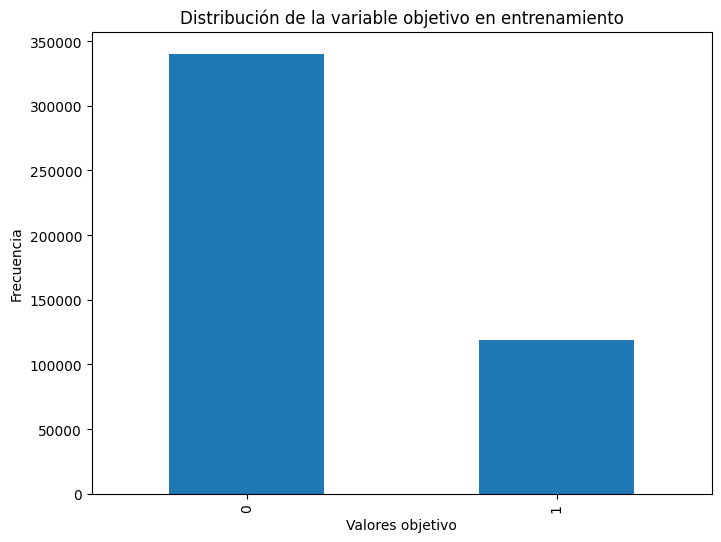

In [20]:
plt.figure(figsize=(8,6))
train_labels['target'].value_counts().plot(kind='bar')
plt.title('Distribución de la variable objetivo en entrenamiento')
plt.xlabel('Valores objetivo')
plt.ylabel('Frecuencia')
plt.show()

Se observa un gran desbalance en la cantidad de `target = 1` (25,9%) o *impago* a `target = 0` o *pago* (74,1%).

Para observar como se distribuyen algunas de las variables independientes de este dataset, se seleccionarán 2 de cada tipo de variable. Para las variables delincuenciales se analizarán `D_39` y `D_63`, una numérica y una categórica respectivamente. Para las de gasto `S_2` y `S_22`, para pagos `P_2` y `P_3`, de balance y riesgo `B_30` (categórica), `B_39` (numérica), `R_3` y `R_20`.

$\Large \textsf{D\_39}$

In [21]:
pd.DataFrame(train_data['D_39'].describe())

D_39
count  5.531451e+06
mean   1.531172e-01
std    2.700709e-01
min    5.026190e-09
25%    4.528464e-03
50%    9.056902e-03
75%    2.366407e-01
max    5.389619e+00

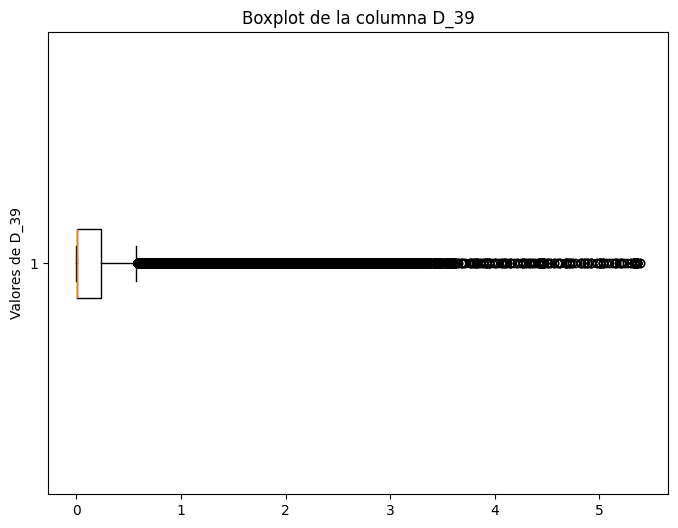

In [22]:
plt.figure(figsize=(8,6))
plt.boxplot(train_data['D_39'].dropna(), vert= False)  # Usamos dropna() para eliminar los valores nulos
plt.title('Boxplot de la columna D_39')
plt.ylabel('Valores de D_39')
plt.show()

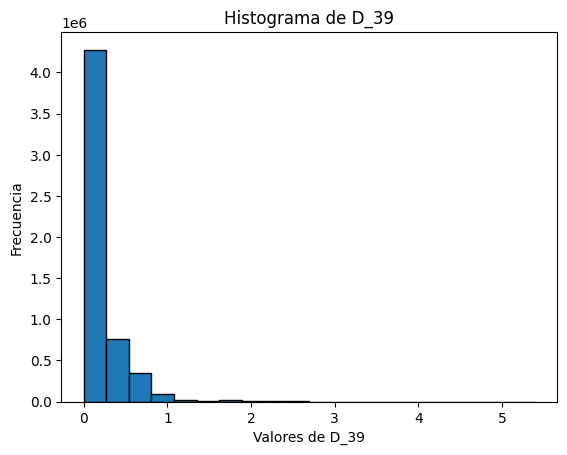

In [23]:
plt.hist(train_data['D_39'], bins=20, edgecolor='black')
plt.title('Histograma de D_39')
plt.xlabel('Valores de D_39')
plt.ylabel('Frecuencia')
plt.show()

Del resumen estadístico se esperaba la asimetría positiva debido a la diferencia entre la mediana y la media (lo cual también sugiere la presencia de datos atípicos altos), asimetría observada en el boxplot. Los valores van desde casi cero hasta 5.39 donde la mitad de los datos se encuentra entre 0.0045 (25%) y 0.2366 (75%), con una mediana de 0.009. Además de euna desviación estándar de 0.270, lo que sugiere una dispersión moderada alrededor de la media.


In [24]:
fa.missing_per(train_data['D_39'])

np.float64(0.0)

Esta variable no cuenta con datos faltantes.


$\Large \textsf{D\_63}$

In [25]:
pd.DataFrame(train_data['D_63'].describe())

D_63
count   5531451
unique        6
top          CO
freq    4119621

In [26]:
train_data['D_63'].unique()

array(['CR', 'CO', 'CL', 'XZ', 'XM', 'XL'], dtype=object)

In [27]:
fa.missing_per(train_data['D_63'])

np.float64(0.0)

`D_63` es una variable categórica asociada a delincuencia con 6 categorías diferentes: CR, CO, CL, XZ, XM y XL la cual tampoco cuenta con datos faltantes.

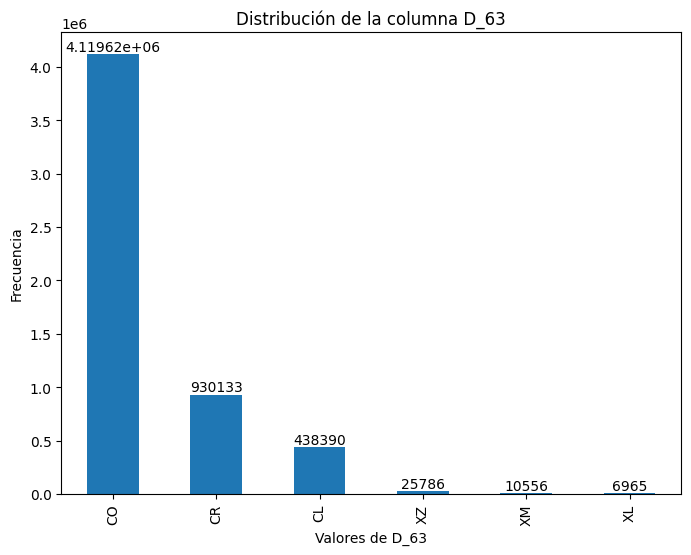

In [28]:
plt.figure(figsize=(8,6))
bar_plot = train_data['D_63'].value_counts().plot(kind='bar')

for i in bar_plot.containers:
    bar_plot.bar_label(i)

plt.title('Distribución de la columna D_63')
plt.xlabel('Valores de D_63')
plt.ylabel('Frecuencia')
plt.show()

La categoría más frecuente fue CO, seguida de CR, CL y XZ, y por último XM y XL con una gran diferencia en la cantidad de registros por categoría. 

$\Large \textsf{S\_2}$

In [29]:
train_data['S_2'].describe

<bound method NDFrame.describe of 0          2017-03-09
1          2017-04-07
2          2017-05-28
3          2017-06-13
4          2017-07-16
              ...    
5531446    2017-11-05
5531447    2017-12-23
5531448    2018-01-06
5531449    2018-02-06
5531450    2018-03-14
Name: S_2, Length: 5531451, dtype: object>

<Axes: xlabel='S_2'>

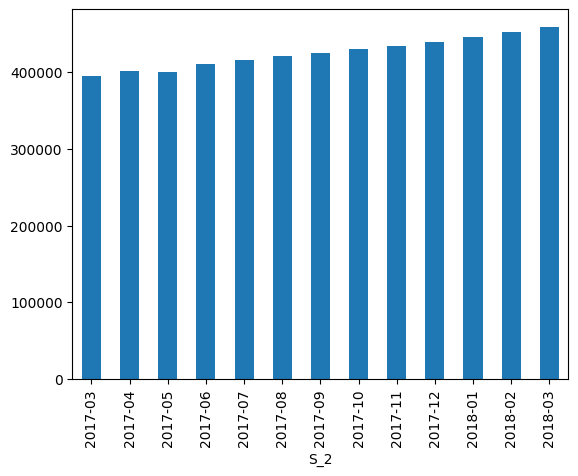

In [30]:
train_data['S_2'] = pd.to_datetime(train_data['S_2'], errors='coerce')
train_data['S_2'].dt.to_period('M').value_counts().sort_index().plot(kind='bar')

In [31]:
train_data['S_2'].dt.to_period('M').value_counts().sort_index()

S_2
2017-03    395630
2017-04    401556
2017-05    400306
2017-06    410384
2017-07    415602
2017-08    421099
2017-09    425455
2017-10    430292
2017-11    434268
2017-12    438910
2018-01    446255
2018-02    452781
2018-03    458913
Freq: M, Name: count, dtype: int64

Se observa un crecimiento constante en el conteo a lo largo de los 13 meses de observaciones, con un incremento mensual casi continuo, esto sugiere que hay una tendencia positiva en el número de registros por mes.

In [32]:
fa.missing_per(train_data['S_2'])

np.float64(0.0)

En `S_2` tampoco se encuentran valores faltantes.

$\Large \textsf{S\_22}$

In [33]:
fa.missing_per(train_data['S_22'])

np.float64(0.3439242253072476)

En esta variable de costos está compuesta en un 0.34% (19024 observaciones) de datos faltantes, un porcentaje bastante pequeño. 

In [34]:
pd.DataFrame(train_data['S_22'].describe())

S_22
count  5.512427e+06
mean   7.791037e-01
std    7.187471e-01
min   -9.199816e+01
25%    8.111971e-01
50%    9.422135e-01
75%    9.647727e-01
max    1.032727e+00

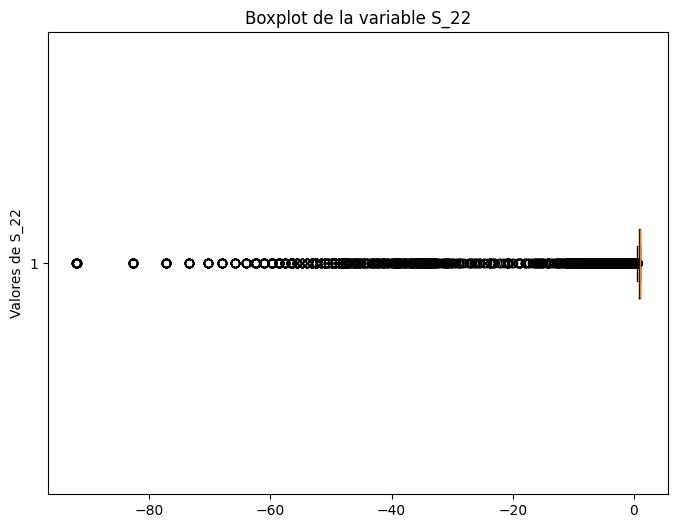

In [35]:
plt.figure(figsize=(8,6))
plt.boxplot(train_data['S_22'].dropna(), vert= False)  # Usamos dropna() para eliminar los valores nulos
plt.title('Boxplot de la variable S_22')
plt.ylabel('Valores de S_22')
plt.show()

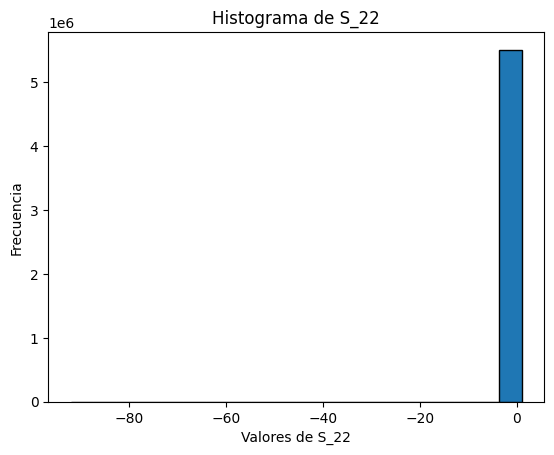

In [36]:
plt.hist(train_data['S_22'], bins=20, edgecolor='black')
plt.title('Histograma de S_22')
plt.xlabel('Valores de S_22')
plt.ylabel('Frecuencia')
plt.show()

Del resumen estadístico y el boxplot, se observa una asimetría negativa con la presencia de valores atípicos bajos que influyen en la distribución. Los datos varían desde un mínimo de -91.999 hasta un máximo de 1.033, indicando una amplia gama de valores. La mitad central de los datos se encuentra entre 0.812 (25%) y 0.965 (75%), lo que revela una concentración en la parte alta de la distribución. La desviación estándar de 0.718 sugiere una dispersión considerable alrededor de la media. Esta variabilidad se refleja en el boxplot, donde se evidencian outliers en la parte baja.

$\Large \textsf{P\_2}$

In [37]:
fa.missing_per(train_data['P_2'])

np.float64(0.8313370216964772)

In [38]:
train_data['P_2'].isnull().sum()

np.int64(45985)

Para la variable `P_2` falta el 0.83% de las observaciones, es decir, 45985 registros vacíos.

In [39]:
pd.DataFrame(train_data['P_2'].describe())

P_2
count  5.485466e+06
mean   6.563340e-01
std    2.446494e-01
min   -4.589548e-01
25%    4.803307e-01
50%    6.942950e-01
75%    8.648159e-01
max    1.010000e+00

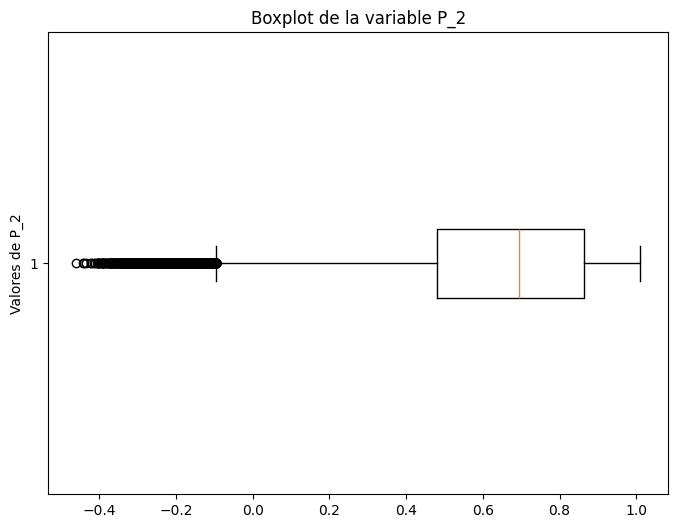

In [40]:
plt.figure(figsize=(8,6))
plt.boxplot(train_data['P_2'].dropna(), vert= False)  # Usamos dropna() para eliminar los valores nulos
plt.title('Boxplot de la variable P_2')
plt.ylabel('Valores de P_2')
plt.show()

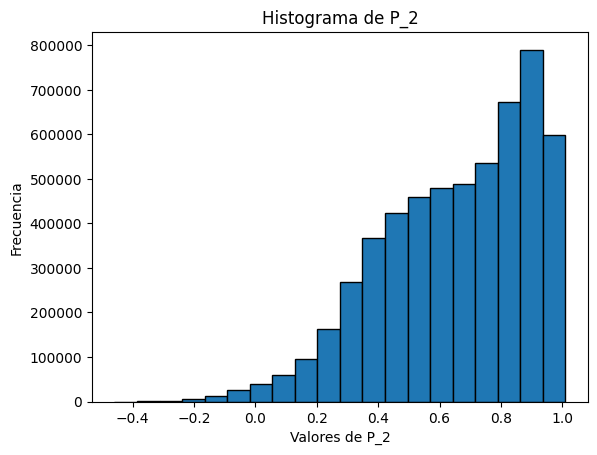

In [41]:
plt.hist(train_data['P_2'], bins=20, edgecolor='black')
plt.title('Histograma de P_2')
plt.xlabel('Valores de P_2')
plt.ylabel('Frecuencia')
plt.show()

Del resumen estadístico y el gráfico se llega a la existencia de una asimetría negativa en la variable y con ello la presencia de valores atípicos bajos. Los valores varían desde un mínimo de -0.459 hasta un máximo de 1.010 y el 50% central de los datos se concentra entre 0.480 (25%) y 0.865 (75%), lo que indica que la mayoría de las observaciones están en el rango superior.

$\Large \textsf{P\_3}$

In [42]:
fa.missing_per(train_data['P_3'])

np.float64(5.450504759058699)

In [43]:
train_data['P_3'].isnull().sum()

np.int64(301492)

Para la variable `P_3` falta el 5.45% de las observaciones, es decir, 301492 registros vacíos.

In [44]:
pd.DataFrame(train_data['P_3'].describe())

P_3
count  5.229959e+06
mean   6.012886e-01
std    1.707992e-01
min   -1.519690e+00
25%    5.408657e-01
50%    6.183025e-01
75%    6.838264e-01
max    2.428051e+00

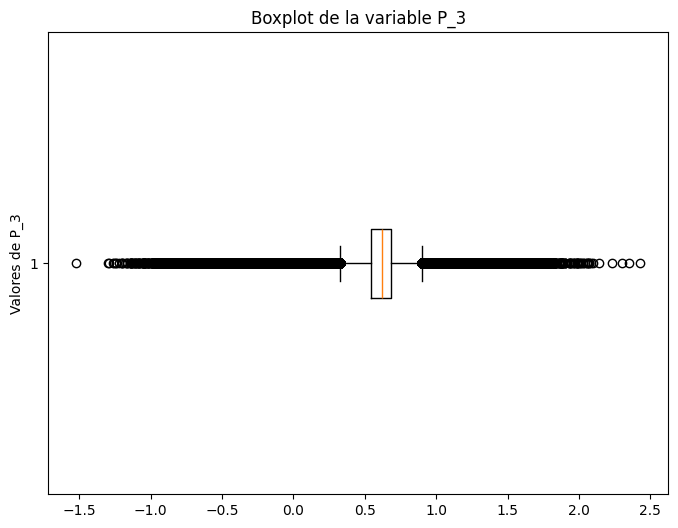

In [45]:
plt.figure(figsize=(8,6))
plt.boxplot(train_data['P_3'].dropna(), vert= False)  # Usamos dropna() para eliminar los valores nulos
plt.title('Boxplot de la variable P_3')
plt.ylabel('Valores de P_3')
plt.show()

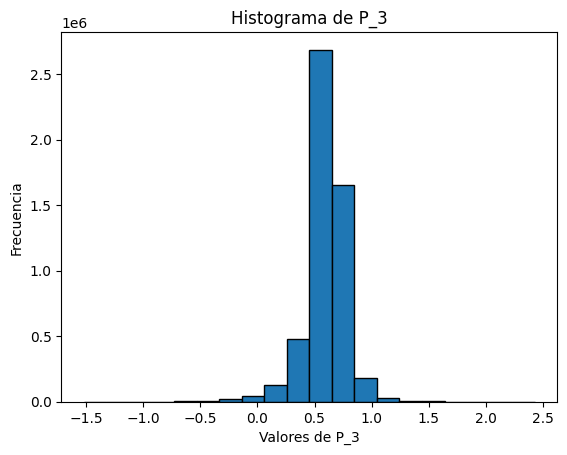

In [46]:
plt.hist(train_data['P_3'], bins=20, edgecolor='black')
plt.title('Histograma de P_3')
plt.xlabel('Valores de P_3')
plt.ylabel('Frecuencia')
plt.show()

`P_3` muestra una distribución más equilibrada en comparación a las variables vistas anteriormente, con una media de 0.601 y una mediana de 0.618, indicando que no hay una asimetría significativa. Los valores oscilan desde un mínimo de -1.520 hasta un máximo de 2.428. El 50% de las observaciones se sitúa entre 0.541 (25%) y 0.684 (75%), lo que sugiere que la mayoría de los datos se agrupan en la parte central y un poco superior de la distribución. Con una desviación estándar de 0.171, la dispersión alrededor de la media es moderada, lo que refuerza la idea de que los datos están relativamente concentrados. en el boxplot se observa esa distribución un poco más centrada, sin embargo, existen una gran cantidad de datos atípicos tanto a la izquierda como a la derecha de los bigotes.

$\Large \textsf{B\_30}$

In [47]:
pd.DataFrame(train_data['B_30'].describe())

B_30
count   5529435
unique        3
top         0.0
freq    4710663

In [48]:
train_data['B_30'] = train_data['B_30'].replace('nan', np.nan)
train_data['B_30'].unique()

array(['0.0', '2.0', '1.0', nan], dtype=object)

In [49]:
fa.missing_per(train_data['B_30'])

np.float64(0.0364461332117016)

In [50]:
train_data['B_30'].isnull().sum()

np.int64(2016)

`B_30` es una variable categórica asociada a delincuencia con 3 categorías diferentes: 0.0, 2.0 y 1.0 la cual cuenta con un 0.03% (2016) de registros faltantes.

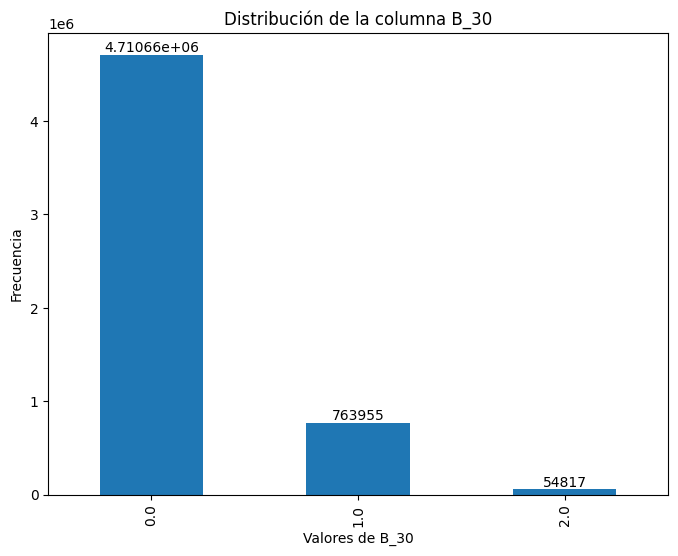

In [51]:
plt.figure(figsize=(8,6))
bar_plot = train_data['B_30'].value_counts().plot(kind='bar')

for i in bar_plot.containers:
    bar_plot.bar_label(i)

plt.title('Distribución de la columna B_30')
plt.xlabel('Valores de B_30')
plt.ylabel('Frecuencia')
plt.show()

La categoría más frecuente fue 0.0, seguida de 1.0 y por último 2.0 con una gran diferencia en la cantidad de registros por categoría. 

$\Large \textsf{B\_39}$

In [52]:
fa.missing_per(train_data['B_39'])

np.float64(99.39198593642065)

In [53]:
train_data['B_39'].isnull().sum()

np.int64(5497819)

En esta variable de balance está compuesta en un 99.39% (5497819 observaciones) de datos faltantes, un porcentaje extremadamente alto.

In [54]:
pd.DataFrame(train_data['B_39'].describe())

B_39
count  33632.000000
mean       0.255473
std        0.297895
min       -0.979314
25%        0.058394
50%        0.149225
75%        0.291426
max        2.060899

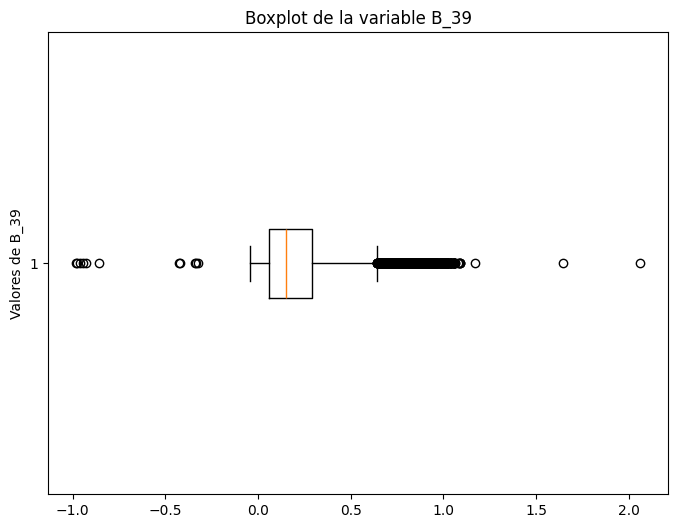

In [55]:
plt.figure(figsize=(8,6))
plt.boxplot(train_data['B_39'].dropna(), vert= False)  # Usamos dropna() para eliminar los valores nulos
plt.title('Boxplot de la variable B_39')
plt.ylabel('Valores de B_39')
plt.show()

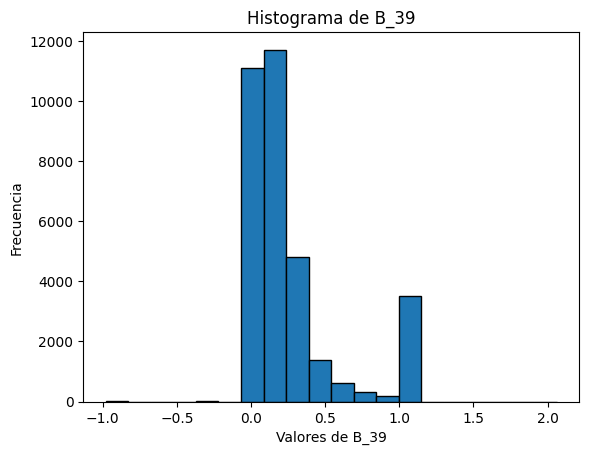

In [56]:
plt.hist(train_data['B_39'], bins=20, edgecolor='black')
plt.title('Histograma de B_39')
plt.xlabel('Valores de B_39')
plt.ylabel('Frecuencia')
plt.show()

Se nota una asimetría positiva. Los valores oscilan entre un mínimo de -0.979 y un máximo de 2.061, lo que indica una variabilidad considerable. El 50% central de las observaciones se concentra entre 0.058 (25%) y 0.291 (75%), lo que sugiere que la mayoría de los datos están agrupados en el rango bajo y medio. Con una desviación estándar de 0.298, la dispersión alrededor de la media es notable, observado en el boxplot, donde se aprecian valores atípicos con mayor frecuencia a la derecha de los bigotes, aunque aún así hay varios a la parte izquierda, es decir, a valores más pequeños.

$\Large \textsf{R\_3}$


In [57]:
fa.missing_per(train_data['R_3'])

np.float64(0.0)

In [58]:
train_data['R_3'].isnull().sum()

np.int64(0)

En esta variable de riesgo no posee datos faltantes. 

In [59]:
pd.DataFrame(train_data['R_3'].describe())

R_3
count  5.531451e+06
mean   1.208287e-01
std    2.105157e-01
min    2.238322e-09
25%    4.700085e-03
50%    9.400614e-03
75%    2.003358e-01
max    1.160260e+01

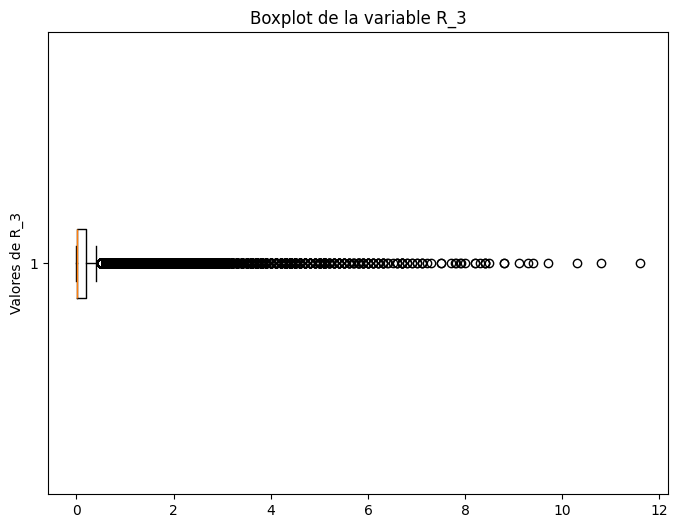

In [60]:
plt.figure(figsize=(8,6))
plt.boxplot(train_data['R_3'].dropna(), vert= False)  # Usamos dropna() para eliminar los valores nulos
plt.title('Boxplot de la variable R_3')
plt.ylabel('Valores de R_3')
plt.show()

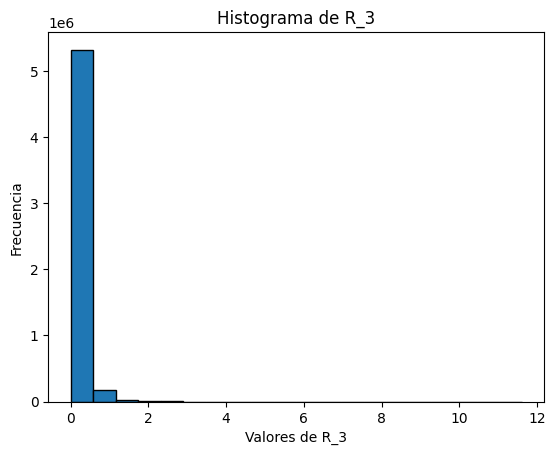

In [61]:
plt.hist(train_data['R_3'], bins=20, edgecolor='black')
plt.title('Histograma de R_3')
plt.xlabel('Valores de R_3')
plt.ylabel('Frecuencia')
plt.show()

Se puede notar una fuerte asimetría positiva en `R_3`. El valor mínimo es prácticamente cero (2.23e-09). En cuanto a los cuartiles, el 25% de los datos están por debajo de 0.0047, el 50% (la mediana) es de 0.0094, y el 75% no supera 0.20, es decir, la mayoría de los valores están concentrados cerca de los mínimos, mientras que existen algunos valores mucho más altos que empujan la cola hacia la derecha, con un valor máximo de 11.60, indicando la presencia de outliers en la parte derecha de los bigotes, confirmado por el boxplot.

$\Large \textsf{R\_20}$

In [62]:
fa.missing_per(train_data['R_20'])

np.float64(0.0013558829319829462)

In [63]:
train_data['R_20'].isnull().sum()

np.int64(75)

En esta variable de riesgo está compuesta en un 0.001% (75 observaciones) de datos faltantes, un valor bastante pequeño.

In [64]:
pd.DataFrame(train_data['R_20'].describe())

R_20
count  5.531376e+06
mean   3.694556e-02
std    3.780643e-01
min    4.972086e-09
25%    2.537703e-03
50%    5.075567e-03
75%    7.614203e-03
max    4.500603e+01

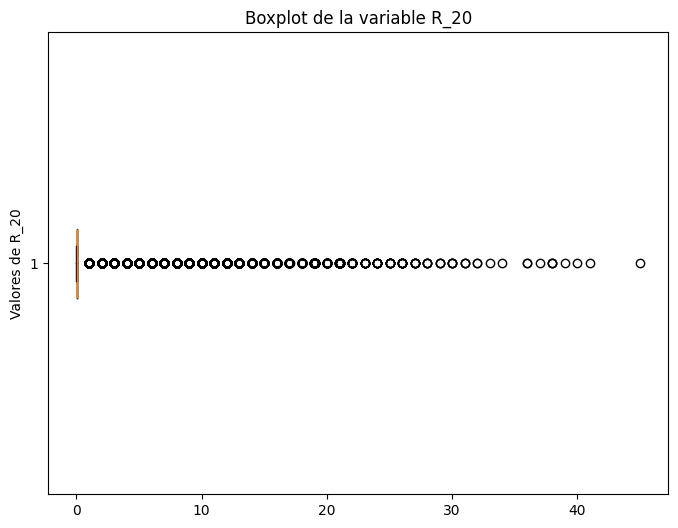

In [65]:
plt.figure(figsize=(8,6))
plt.boxplot(train_data['R_20'].dropna(), vert= False)  # Usamos dropna() para eliminar los valores nulos
plt.title('Boxplot de la variable R_20')
plt.ylabel('Valores de R_20')
plt.show()

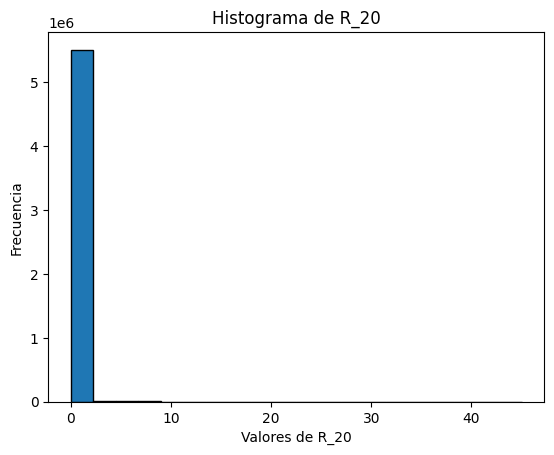

In [66]:
plt.hist(train_data['R_20'], bins=20, edgecolor='black')
plt.title('Histograma de R_20')
plt.xlabel('Valores de R_20')
plt.ylabel('Frecuencia')
plt.show()

Para la variable `R_20`, la media es de 0.0369 con una desviación estándar considerablemente alta (0.378), lo que indica una gran dispersión en los datos. Los cuartiles muestran que el 25% de los datos son menores a 0.0025, el 50% (la mediana) es de 0.0051, y el 75% no supera 0.0076, lo que indica una fuerte asimetría positiva. Aunque la mayoría de los datos están muy cerca de cero, el valor máximo de 45.006 sugiere la presencia de valores extremadamente altos (outliers), lo que contribuye a la larga cola derecha en la distribución de los datos.



# Análisis bivariado
cat: 	customer_ID	S_2	D_63	D_64	D_66	D_68	B_30	B_38	D_114	D_116	D_117	D_120	D_126
Consideramos pertinente revisar 

## `target` y `D_63`

In [67]:
temp = pd.merge(train_data[['customer_ID','D_63']], train_labels, on='customer_ID', how='left')

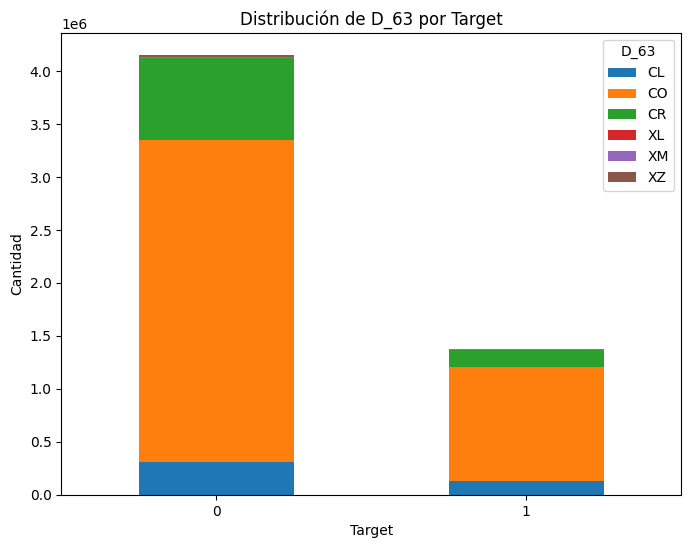

In [68]:
counts = temp.groupby(['target', 'D_63']).size().unstack(fill_value=0)
counts.plot(kind='bar', stacked=True, figsize=(8, 6))

plt.title('Distribución de D_63 por Target')
plt.xlabel('Target')
plt.ylabel('Cantidad')
plt.legend(title='D_63')
plt.xticks(rotation=0)
plt.show()

In [69]:
counts

D_63        CL       CO      CR    XL    XM     XZ
target                                            
0       310865  3036914  772136  4754  8050  20863
1       127525  1082707  157997  2211  2506   4923

Existe una gran diferencia entre la proporcion de cada categoría de `D_63` tanto en 0 y 1, sin embargo parece mantenerse proprcional entre ambas categorías de `target`. En ambas categorías, **CO** cuenta con una mayor frecuencia, seguida por **CR** y **CL**, siendo **XL** la categoría con menos registros en ambas.

## `target` y `B_38`

In [70]:
temp = pd.merge(train_data[['customer_ID','B_38']], train_labels, on='customer_ID', how='left')

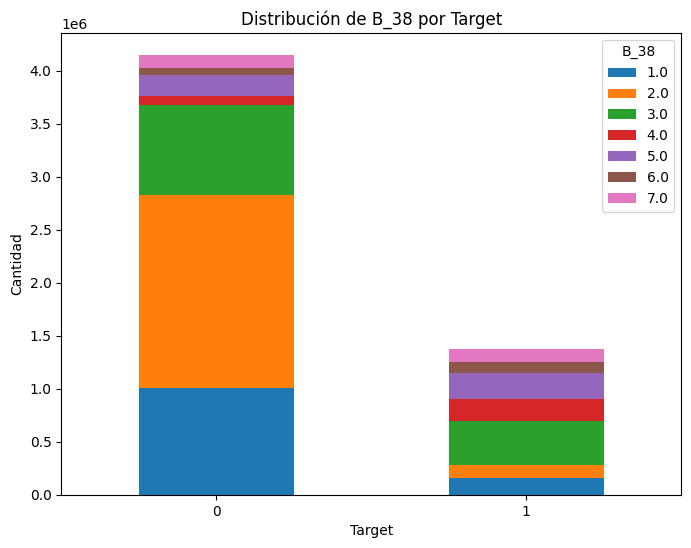

In [71]:
counts = temp.groupby(['target', 'B_38']).size().unstack(fill_value=0)
counts.plot(kind='bar', stacked=True, figsize=(8, 6))

plt.title('Distribución de B_38 por Target')
plt.xlabel('Target')
plt.ylabel('Cantidad')
plt.legend(title='B_38')
plt.xticks(rotation=0)
plt.show()

In [72]:
counts

B_38        1.0      2.0     3.0     4.0     5.0    6.0     7.0
target                                                         
0       1003134  1829580  842814   88559  195990  62399  129808
1        156913   123652  412501  206358  248866  99641  129220

A diferencia del análisis anterior, aquí las proprciones no parecen mantenerse entre ambas categorías de la variable `target`. En 0, la categoría de `B_38` 2.0 fue la más frecuente, sin embargo, en 1 fue 3.0. En ambas coincide que 6.0 es la categoría de `B_38` menos frecuente.

## `target` y `D_92`

In [73]:
temp = pd.merge(train_data[['customer_ID','D_92']], train_labels, on='customer_ID', how='left')

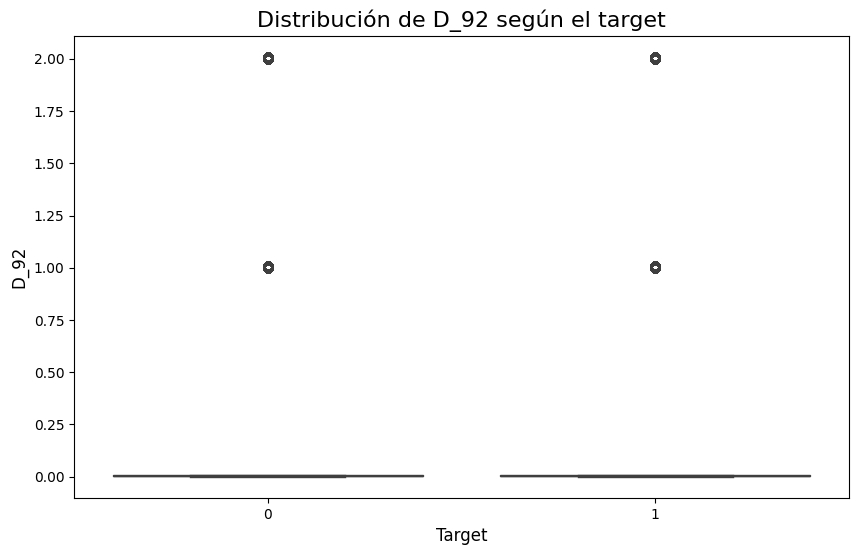

In [74]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='D_92', data=temp)
plt.title('Distribución de D_92 según el target', fontsize=16)
plt.xlabel('Target', fontsize=12)
plt.ylabel('D_92', fontsize=12)
plt.show()

In [75]:
temp.groupby('target')['D_92'].describe().T

target             0             1
count   4.153582e+06  1.377869e+06
mean    1.159931e-01  1.573589e-02
std     3.289231e-01  1.114235e-01
min     2.088378e-09  1.973984e-08
25%     2.794622e-03  2.525871e-03
50%     5.592227e-03  5.052954e-03
75%     8.390171e-03  7.576226e-03
max     2.010000e+00  2.009996e+00

In [76]:
2.009996 - 2.010000

-3.9999999996709334e-06

Del `describe()` y gráfica de ambos conjuntos de datos se puede observar una diferencia entre la proporción de clases, la clase 0 tiene más de cuatro millones de observaciones mientras que la clase 0 solo cuenta con menos de millón y medio de observaciones, esto refuerza la idea de que estamos tratando con un problema desbalanceado. La media de aquellos clientes de la clase 0, es decir, los que no incurrieron en impago es mayor para aquellos que sí incurrieron en impagos, es decir, para esta variable asociada a delincuencia parece que los usuarios cque sí pagaron tienen un valor mayor en ella. La desviación estándar en el grupo de pagos es mayor, es decir, esta variable oresenta una mayor dispersión, en cambio la de impago (1) tiene sus valores más concentrados alrededor de la media. En cuanto a los percentiles, realmente se distribuyen de manera muy similar, en rangos inferiores, lo mismo sucede con los valores mínimos y máximos, teniendo incluso practicamente el mismo valor máximo en ambas clases con una diferencia inferior a 0.000004.

## Selección de variables numéricas para correlación

Debido a la gran cantidad de variables numéricas presentes en el dataset, se realizó una selección aleatoria de variables numéricas para revisar la correlación entre ellas, estas corresponden a las siguientes:

In [46]:
# Resultado obtenido más adelante

numeric_cols = ['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_43', 'D_44', 'B_4', 'D_45', 'B_5', 'R_2', 'D_46', 'D_47', 'D_48', 'B_6', 'B_7', 'B_8', 'D_51', 'B_9', 'R_3', 'D_52', 'P_3', 'B_10', 'S_5', 'B_11', 'S_6', 'D_54', 'R_4', 'S_7', 'B_12', 'S_8', 'D_55', 'B_13', 'R_5', 'D_58', 'B_14', 'D_59', 'D_60', 'D_61', 'B_15', 'S_11', 'D_62', 'D_65', 'B_16', 'B_18', 'B_19', 'B_20', 'S_12', 'R_6', 'S_13', 'B_21', 'D_69', 'B_22', 'D_70', 'D_71', 'D_72', 'S_15', 'B_23', 'P_4', 'D_74', 'D_75', 'B_24', 'R_7', 'D_77', 'B_25', 'B_26', 'D_78', 'D_79', 'R_8', 'S_16', 'D_80', 'R_10', 'R_11', 'B_27', 'D_81', 'S_17', 'R_12', 'B_28', 'R_13', 'D_83', 'R_14', 'R_15', 'D_84', 'R_16', 'S_18', 'D_86', 'R_17', 'R_18', 'B_31', 'S_19', 'R_19', 'B_32', 'S_20', 'R_20', 'R_21', 'B_33', 'D_89', 'R_22', 'R_23', 'D_91', 'D_92', 'D_93', 'D_94', 'R_24', 'R_25', 'D_96', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'D_102', 'D_103', 'D_104', 'D_107', 'B_36', 'B_37', 'R_27', 'D_109', 'D_112', 'B_40', 'S_27', 'D_113', 'D_115', 'D_118', 'D_119', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_127', 'D_128', 'D_129', 'B_41', 'D_130', 'D_131', 'D_133', 'R_28', 'D_139', 'D_140', 'D_141', 'D_143', 'D_144', 'D_145']

In [ ]:
rnc = np.random.choice(numeric_cols, 5, replace=False)
rnc


In [92]:
rnc = ['D_43', 'D_55', 'R_19', 'R_6', 'R_3']

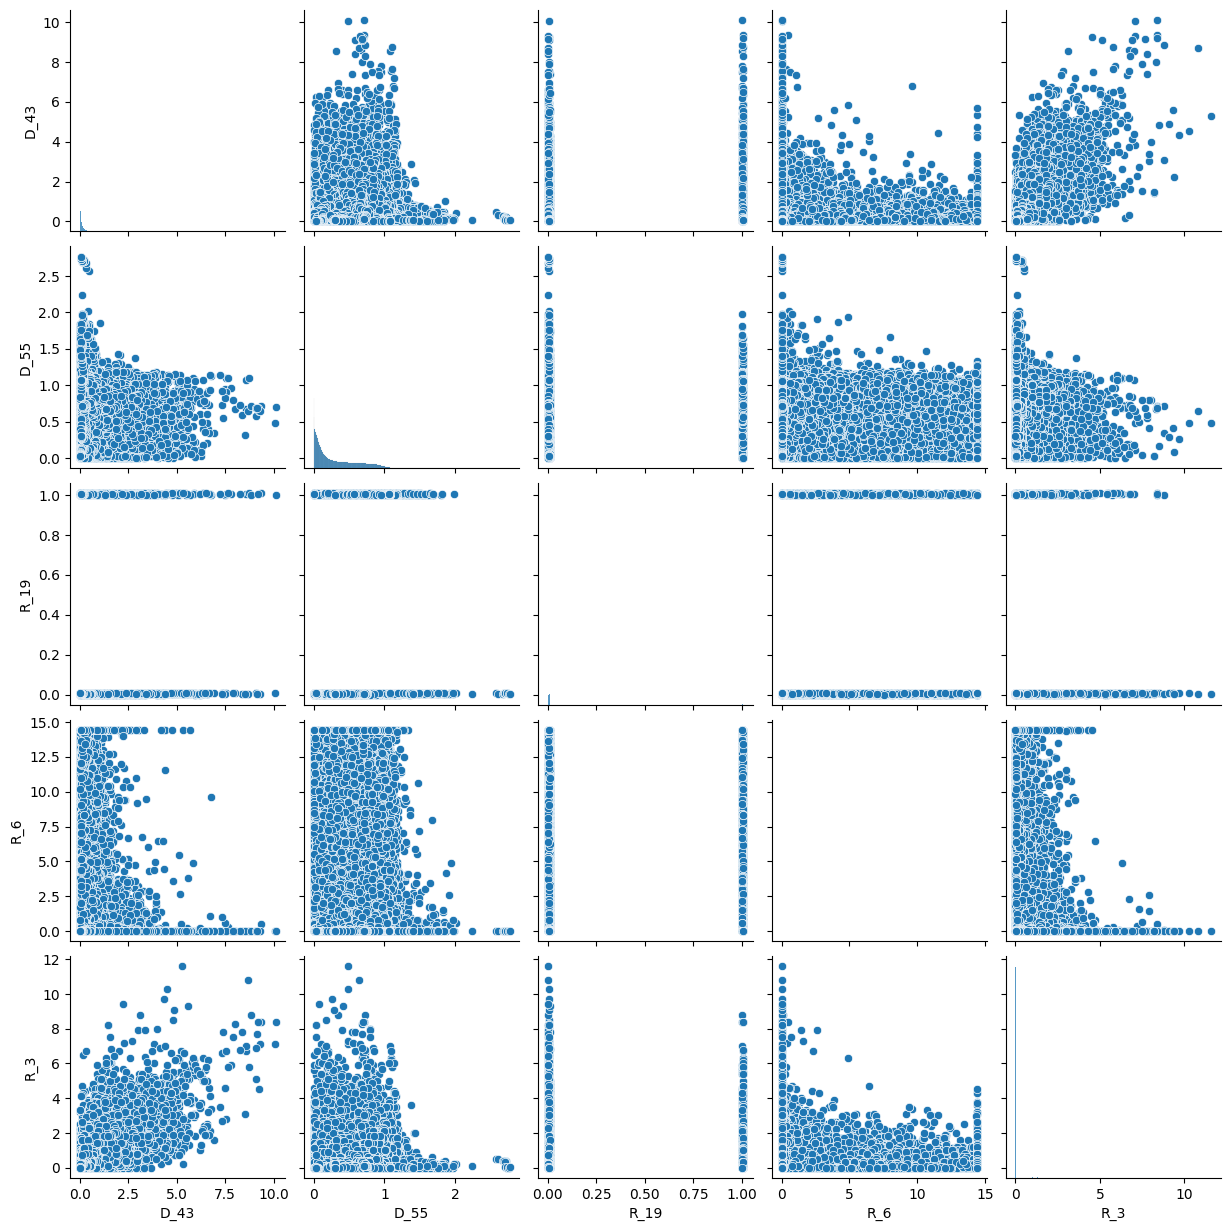

In [119]:
sns.pairplot(train_data[rnc])
plt.show()

Text(0.5, 1.0, 'Matriz de Correlación')

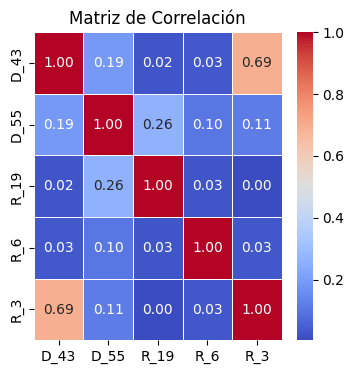

In [120]:
cm = train_data[rnc].corr()
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación')

Realmente no se aprecia ningún tipo de correlación entre la gran mayoría de variables expuestas en la matriz de scatterplot, las únicas variables en  las que se observa la existencia de cierta correlación son las variables de `D_43` y `R_3`, que confirmado con la matriz de correlación asociada a las mismas variables se encuentra un coeficiente de correlación de 0.69, más levemente con un coeficiente de correlación de 0.26 se encuentran las variables `D_55` y `R_19`. Respecto al resto, realmente no superan siquiera el 0.2.

## `D_43` y `R_3`

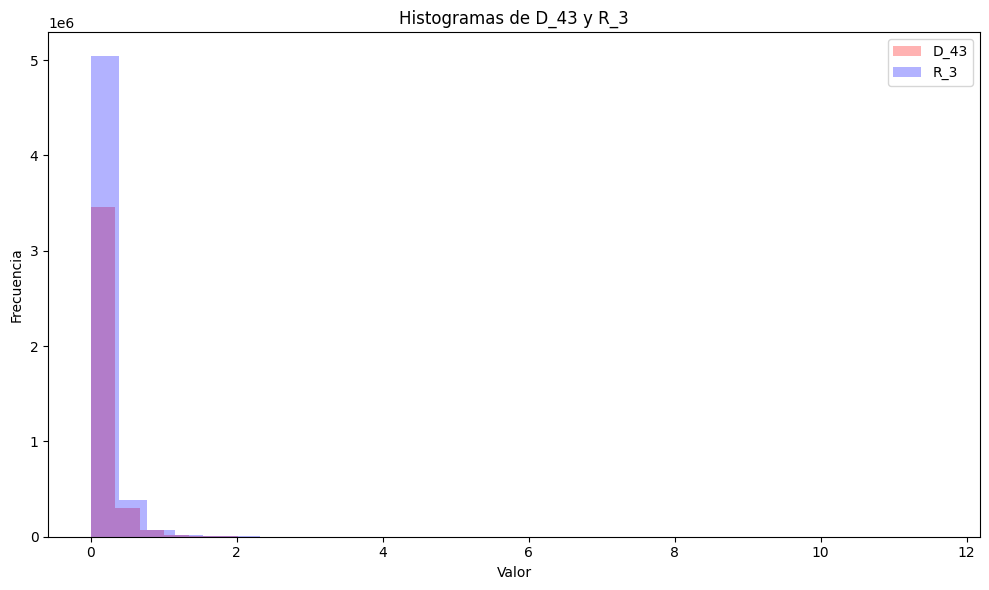

In [133]:
plt.figure(figsize=(10, 6))

plt.hist(train_data['D_43'], bins=30, alpha=0.3, label='D_43', color='red')
plt.hist(train_data['R_3'], bins=30, alpha=0.3, label='R_3', color='blue')

plt.title('Histogramas de D_43 y R_3')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.legend()

plt.tight_layout()
plt.show()

En el histograma superpuesto se puede ver como todos los datos de `D_43` se ven asolapados con los datos de `R_3`, ambas variables parecen tener distribuciones muy similares. 

Text(0, 0.5, 'R_3')

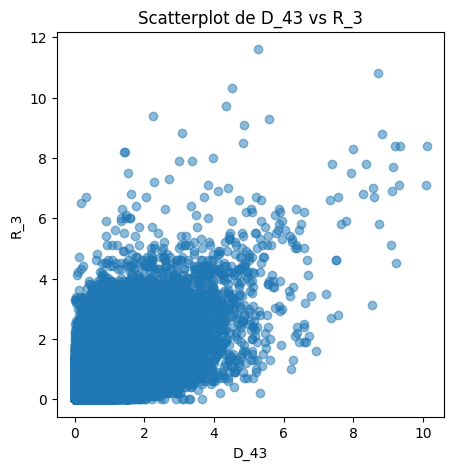

In [127]:
plt.figure(figsize=(5, 5))
plt.scatter(train_data['D_43'], train_data['R_3'], alpha=0.5)
plt.title('Scatterplot de D_43 vs R_3')
plt.xlabel('D_43')
plt.ylabel('R_3')

Este diagrama de dispersión ya visto anteriormente en la matriz, demuestra esa considerable correlación positiva entre ambas variables. 

## `D_55` y `R_19`

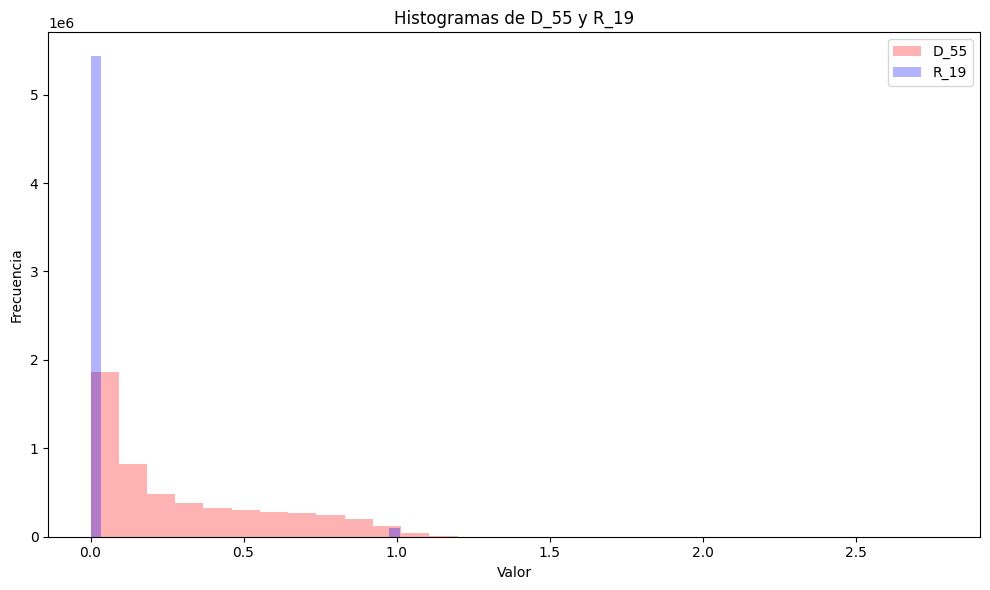

In [135]:
plt.figure(figsize=(10, 6))

plt.hist(train_data['D_55'], bins=30, alpha=0.3, label='D_55', color='red')
plt.hist(train_data['R_19'], bins=30, alpha=0.3, label='R_19', color='blue')

plt.title('Histogramas de D_55 y R_19')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.legend()

plt.tight_layout()
plt.show()

A diferencia de lo visto con las dos variables anteriores, acá no se aprecia ese asolapamiento ebntre ambas variables, no se puede decir nada del comportamiento de ambas conjuntamente, claramente no tienen la misma distribución más que hay un decrecimiento en ambas a medida que aumenta el valor.

Text(0, 0.5, 'R_19')

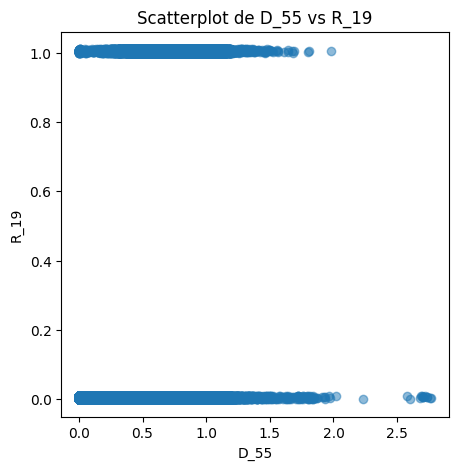

In [136]:
plt.figure(figsize=(5, 5))
plt.scatter(train_data['D_55'], train_data['R_19'], alpha=0.5)
plt.title('Scatterplot de D_55 vs R_19')
plt.xlabel('D_55')
plt.ylabel('R_19')

La interpretación al diagrama de dispersión debido al tipo de variable de `R_19`, al tener solamente dos valores, podría ser un poco complicado. Se observa que cuando `R_19` es 0, el rango de valores de `D_55` aumenta, y cuando es 1,  el rango de valores de `D_55` disminuye levemente.

## `P_2`, `P_3` y `P_4`

Estas variables son las asociadas a pagos. Se verá si existe una correlación entre ellas.

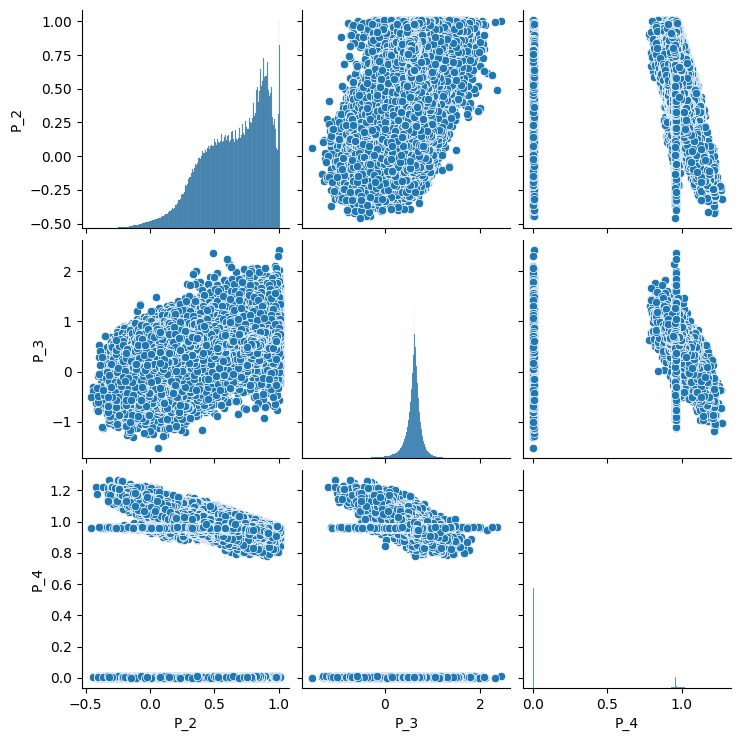

In [137]:
sns.pairplot(train_data[['P_2', 'P_3', 'P_4']])
plt.show()

La distribución de valores tanto de `P_2` y `P_3` respecto a `P_4` es muy similar y bastante extraña. La distribución entre `P_2` y `P_3` demuestra cierta correlación positiva entrE ellas, que si bien podría no ser muy alta, existe. Esto se comprobará al realizar la matriz de correlación.

Text(0.5, 1.0, 'Matriz de Correlación')

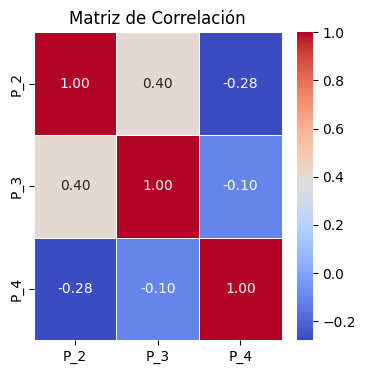

In [138]:
cm = train_data[['P_2', 'P_3', 'P_4']].corr()
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación')

Como era esperado, existe una correlación positiva, no muy alta, entre `P_2` y `P_3` de 0.4. Entre las otras variables realmente se encuentra una correlación bastante baja, esperada también por esa falta de linealñidad observada en la matriz de diagramas de dispersión.

### `P_2` y `P_3` 

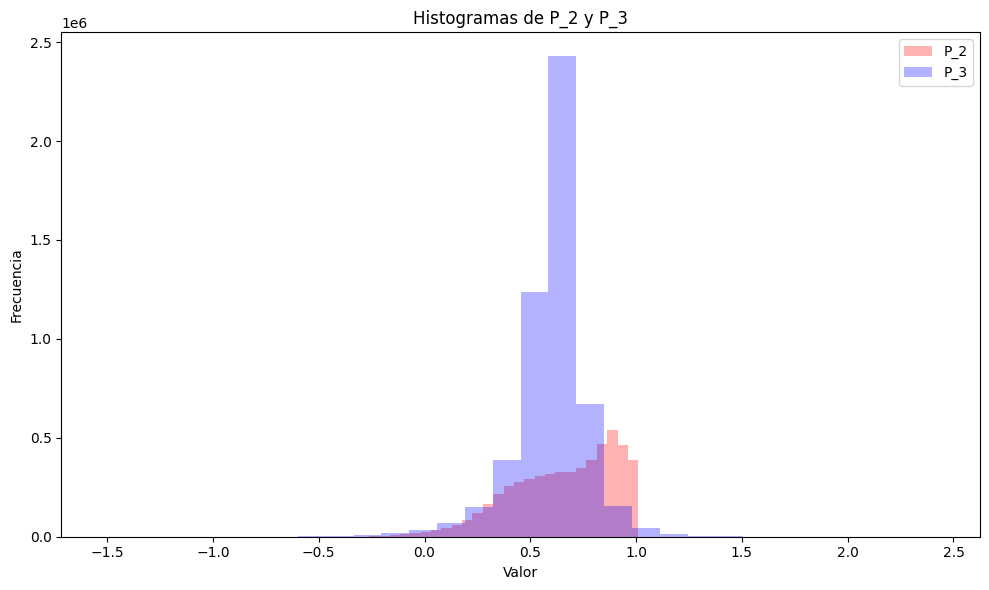

In [139]:
plt.figure(figsize=(10, 6))

plt.hist(train_data['P_2'], bins=30, alpha=0.3, label='P_2', color='red')
plt.hist(train_data['P_3'], bins=30, alpha=0.3, label='P_3', color='blue')

plt.title('Histogramas de P_2 y P_3')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.legend()

plt.tight_layout()
plt.show()

Text(0, 0.5, 'P_3')

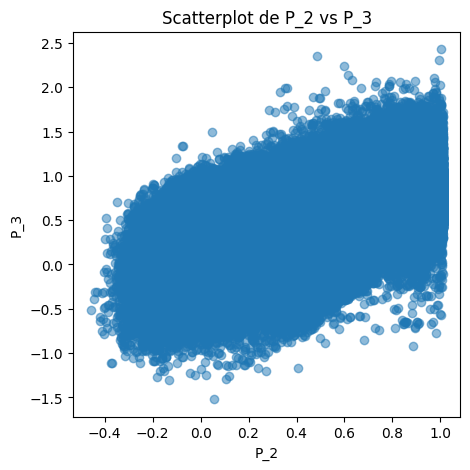

In [140]:
plt.figure(figsize=(5, 5))
plt.scatter(train_data['P_2'], train_data['P_3'], alpha=0.5)
plt.title('Scatterplot de P_2 vs P_3')
plt.xlabel('P_2')
plt.ylabel('P_3')

En el diagrama superpuesto, se aprecia que ambas distribuciones no son parecidas, también si se observa en el diagrama de dispersión, ambas oscilan entre valores diferentes: `P_2` entre -0.4 y 1 y `P_3` entre -1.5 a 2.5.

## Variables de riesgo

Text(0.5, 1.0, 'Matriz de Correlación')

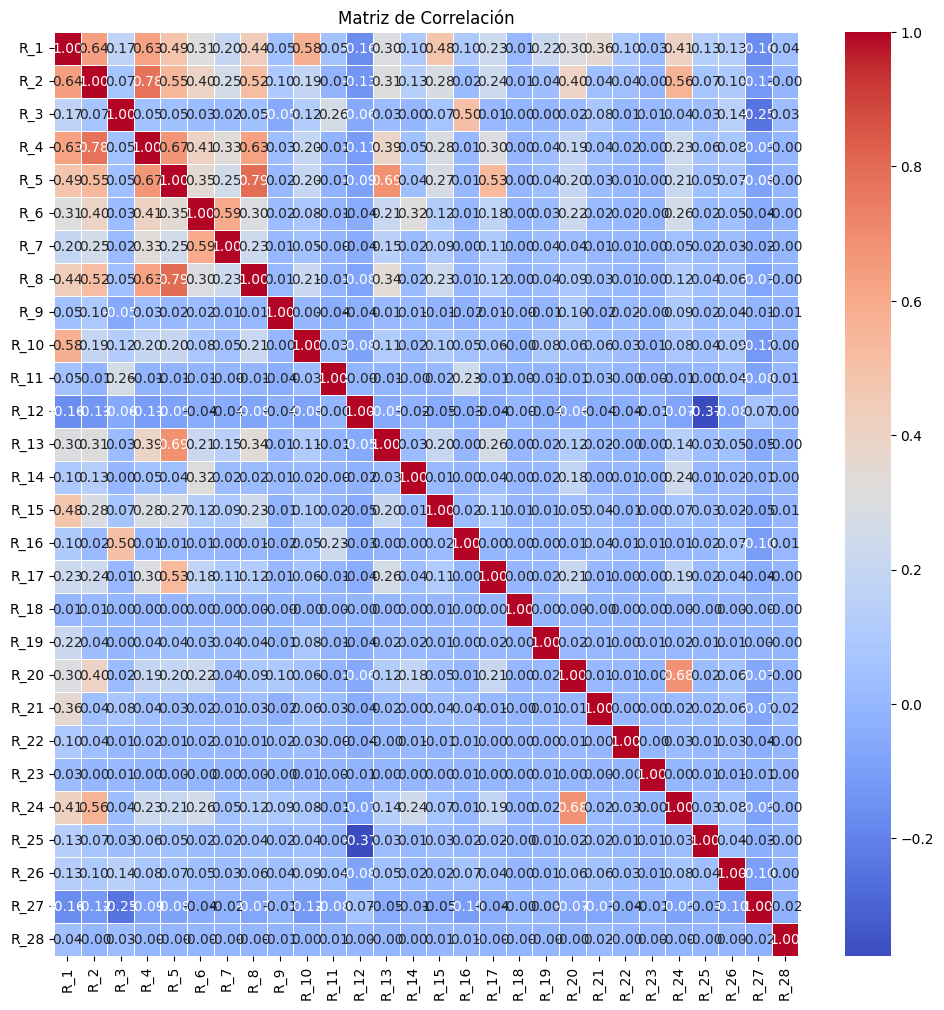

In [146]:
cm = train_data[['R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_12', 'R_13', 'R_14', 'R_15', 'R_16', 'R_17', 'R_18', 'R_19', 'R_20', 'R_21', 'R_22', 'R_23', 'R_24', 'R_25', 'R_26', 'R_27', 'R_28']].corr()
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación')

Se observan correlaciones más fuertes en las primeras variables de riesgo, por lo que para un mejor análisis se limitarán a las primeras 10 variables de riesgo.

Text(0.5, 1.0, 'Matriz de Correlación')

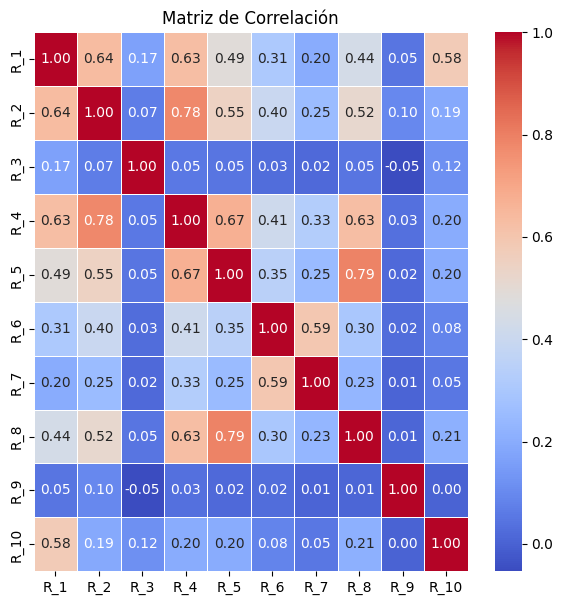

In [148]:
cm = train_data[temp].corr()
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación')

Aquellas variables que presentan mayor correlación son `R_8` - `R_5` (0.79), `R_4` - `R_2` (0.78) y  `R_5` y `R_4` (0.67), lo que llevaría a esperar que `R_2` y `R_5` estén también significativamente correlacionadas. Dentro de este conjunto de variables también hay otras que se encuentran correlacionadas pero ya entre 0.52 y 0.64. Del resto de variables, no se puede decir que existan correlaciones altas entre ellas.  

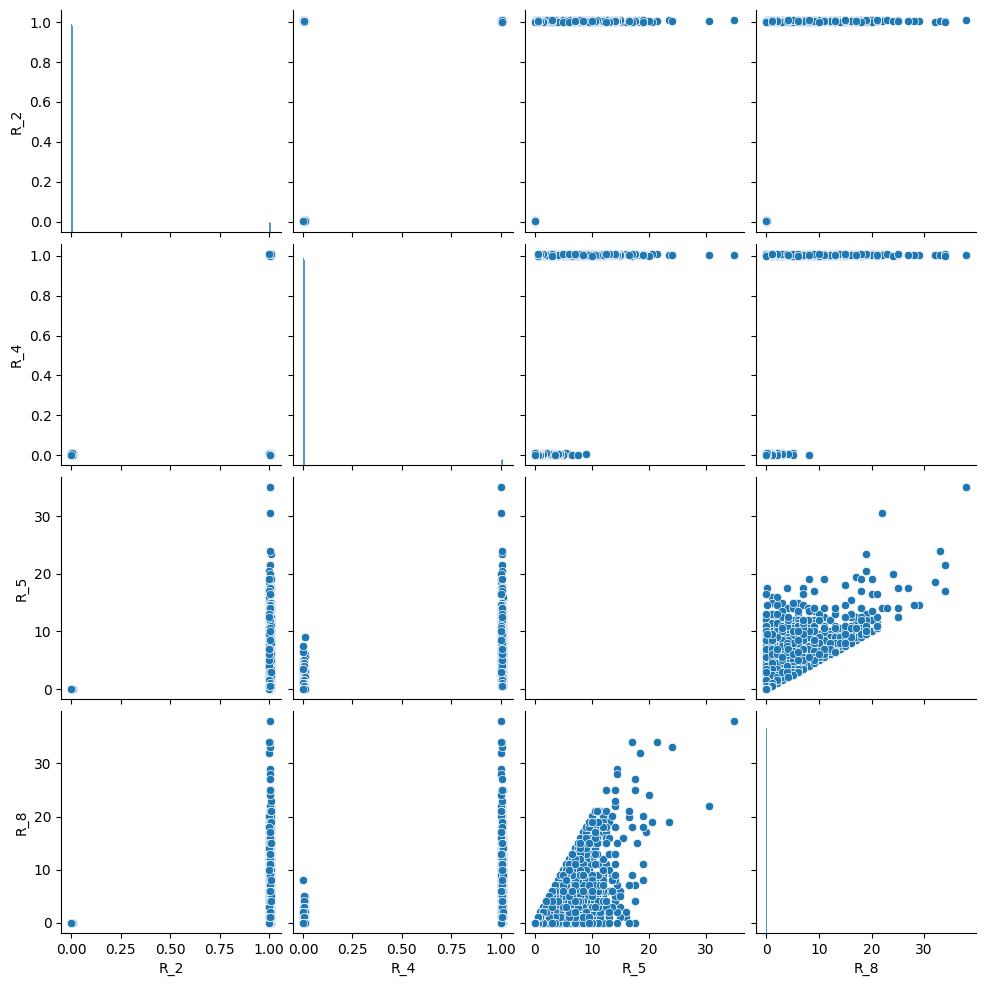

In [14]:
temp = ['R_2', 'R_4', 'R_5', 'R_8']
sns.pairplot(train_data[temp])
plt.show()

Más adelante se interpretará el elemento de la matriz que sea necesario individualmente según elr esultado de la matriz de correlación.

### `R_8` y `R_5`

Estas dos variables cuentan con un coeficiende de correlaciónde 0.79, el más alto entre las variables de riesgo. 

In [7]:
train_data[['R_8', 'R_5']].describe()

R_8           R_5
count  5.531451e+06  5.531451e+06
mean   3.812034e-02  3.459403e-02
std    3.036416e-01  2.568067e-01
min    1.738091e-09  1.154589e-09
25%    2.553690e-03  2.575087e-03
50%    5.105827e-03  5.149018e-03
75%    7.657797e-03  7.721870e-03
max    3.800808e+01  3.500452e+01

Al revisar el resumen estadísitoc, se observa que ambas variables son bastante similares. Sus medias son cercanas, de 0.0381 para `R_8` y 0.0346 para `R_5`. De igual manera, los cuartiles muestran que ambos conjuntos de datos tienen una distribución relativamente similar, aunque `R_8` tiende a ser ligeramente más alto en cada cuartil. Los valoers mínimos, máximos y desviación estándar tampoco difieren mucho. Se esperaría una distribución similar en el histograma superpuesto. Hay una grand iferencia entre el percentil 75 y el valor máximo, lo que sugiere un gran porcentaje de datos atípicos.

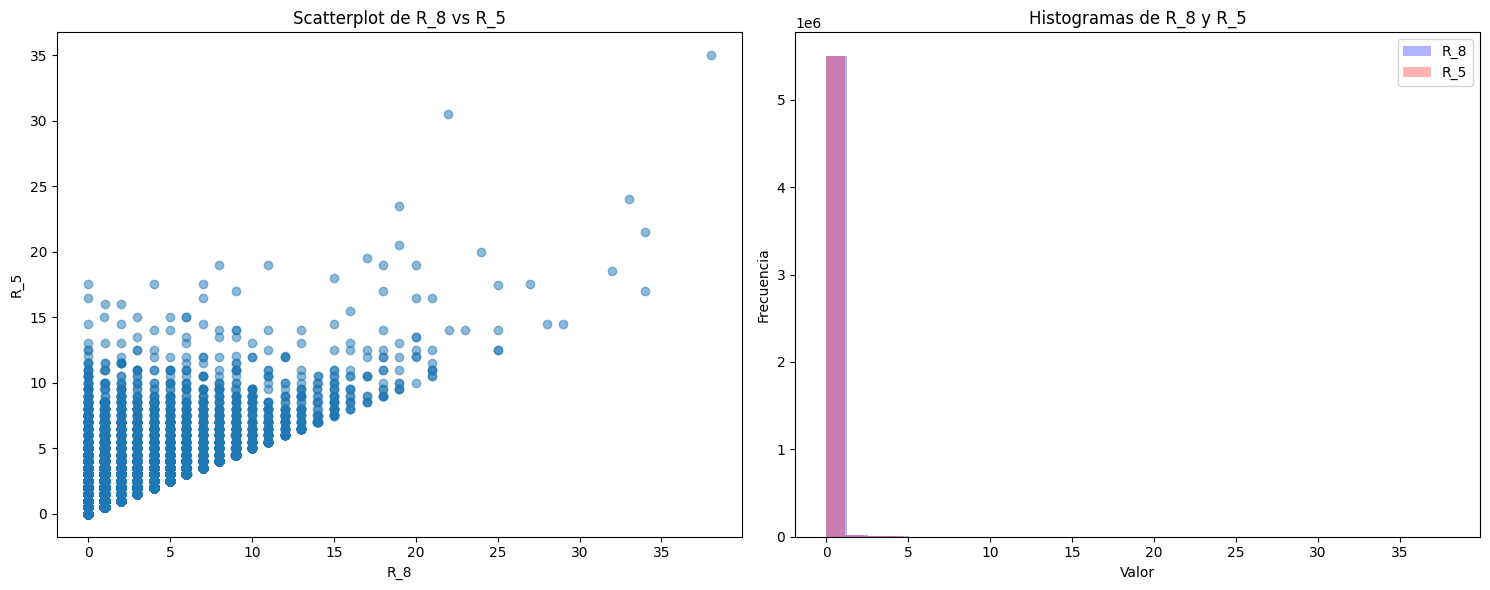

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(train_data['R_8'], train_data['R_5'], alpha=0.5)
ax1.set_title('Scatterplot de R_8 vs R_5')
ax1.set_xlabel('R_8')
ax1.set_ylabel('R_5')

ax2.hist(train_data['R_8'], bins=30, alpha=0.3, label='R_8', color='blue')
ax2.hist(train_data['R_5'], bins=30, alpha=0.3, label='R_5', color='red')
ax2.set_title('Histogramas de R_8 y R_5')
ax2.set_xlabel('Valor')
ax2.set_ylabel('Frecuencia')
ax2.legend()

plt.tight_layout()
plt.show()

Se puede notar esa correlación de casi 0.8, incluso hay una línea bastante clara sobre la que reposan los valores de `R_5` según `R_8`, a mayor valor de `R_8`, más alto es el rango de valores para `R_5`. Tal como se esperaba del resumen estadístico, ambas  variables tienen una distribución bastante similar, donde casi que sus histogramas se superponen completamente. 

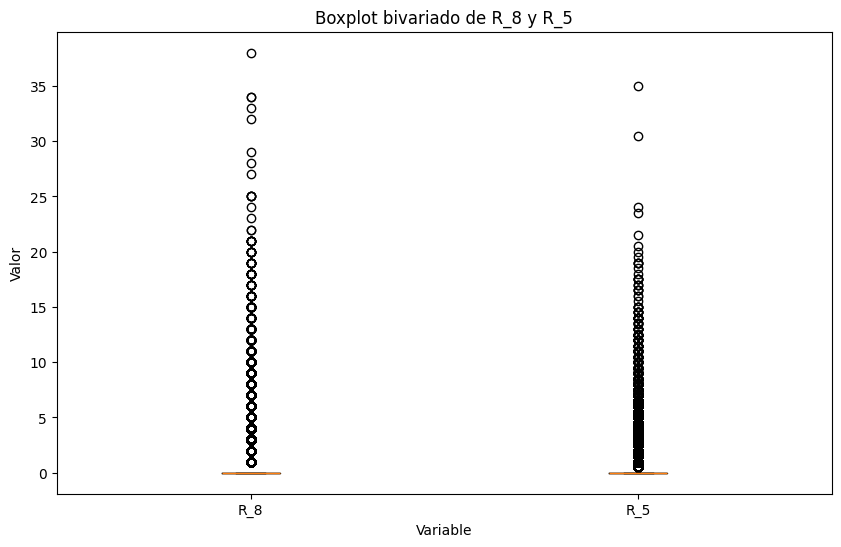

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot([train_data['R_8'], train_data['R_5']], tick_labels=['R_8', 'R_5'])
ax.set_title('Boxplot bivariado de R_8 y R_5')
ax.set_xlabel('Variable')
ax.set_ylabel('Valor')
plt.show()

Se nota la presencia de muchos datos atípicos, tal como se esperaba debido al resumen estadístico.

### `R_4` y `R_2`

In [10]:
train_data[['R_4', 'R_2']].describe()

R_4           R_2
count  5.531451e+06  5.531451e+06
mean   3.120413e-02  4.751791e-02
std    1.597703e-01  2.017843e-01
min    4.024685e-10  8.265748e-10
25%    2.565921e-03  2.613008e-03
50%    5.132659e-03  5.223076e-03
75%    7.700315e-03  7.837339e-03
max    1.010000e+00  1.010000e+00

Al analizar el resumen estadístico de las variables `R_4` y `R_2`, se observa que `R_2` tiende a tener valores más altos en promedio: la media de `R_4` (0.0312) es significativamente menor que la de `R_2` (0.0475). Ambas variables tienen valores mínimos muy bajos, casi ceros, y un máximo de 1.01. Los cuartiles muestran que R_2 tiende a ser ligeramente más alto en cada punto, reforzando la observación de sus valores generalmente más altos. La notable diferencia entre el percentil 75 y el valor máximo sugiere la presencia de un porcentaje significativo de datos atípicos en ambas variables.

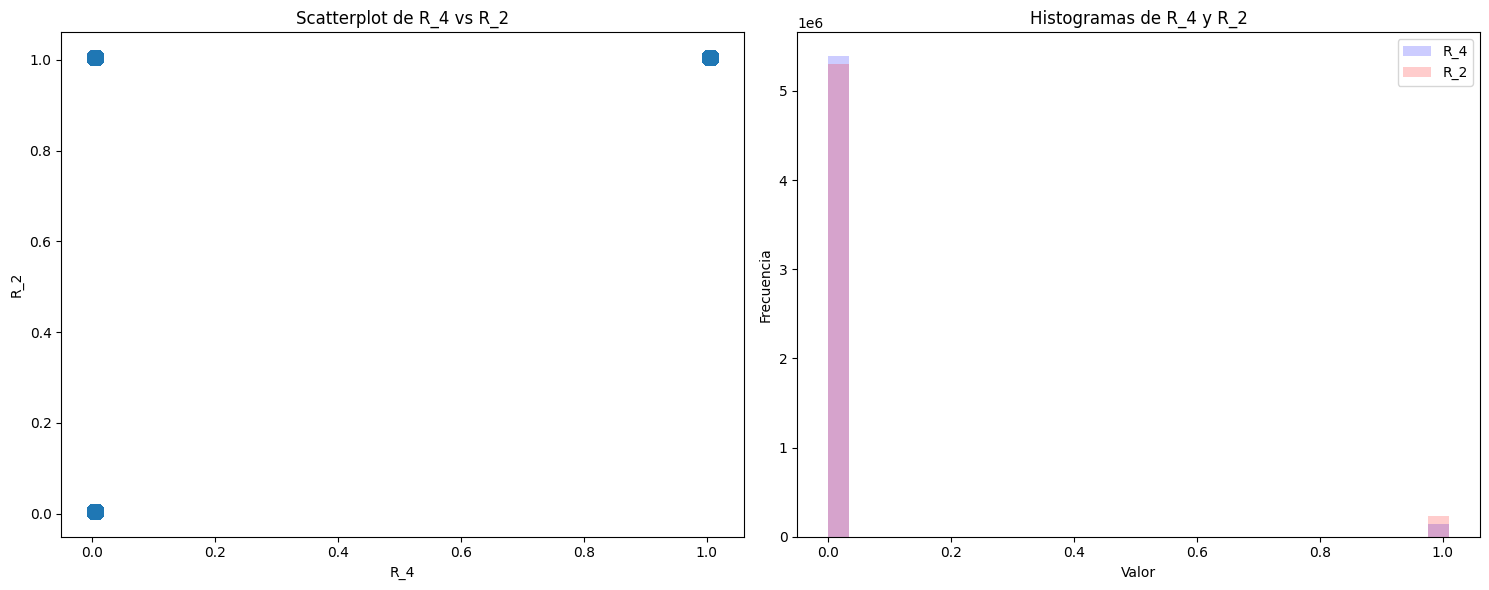

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(train_data['R_4'], train_data['R_2'], alpha=0.5)
ax1.set_title('Scatterplot de R_4 vs R_2')
ax1.set_xlabel('R_4')
ax1.set_ylabel('R_2')

ax2.hist(train_data['R_4'], bins=30, alpha=0.2, label='R_4', color='blue')
ax2.hist(train_data['R_2'], bins=30, alpha=0.2, label='R_2', color='red')
ax2.set_title('Histogramas de R_4 y R_2')
ax2.set_xlabel('Valor')
ax2.set_ylabel('Frecuencia')
ax2.legend()

plt.tight_layout()
plt.show()

La distribución del scatter plot llama bastante la atención, revelando que los registros se encuentran como `R_2` y `R_4` llegando a ser casi 0, o con `R_4` siendo casi 0 y `R_2` 1 aproximadamente o ambos siendo aproximadamente 1, se encuentran bastante concentrados en las esquinas del gráfico con muy poca variación entre los grupos. En el histograma ambas variables siguen la misma distribución, habiendo más registros con `R_4` cerca de 0 (esperado debido a las dos aglomeraciones de puntos observada en el scatter plot) y `R_2` son más datos cercanos a 1 que `R_4` también esperado debido a los dos conjuntos de puntos observados en la parte superior del diagrama de dispersión. 

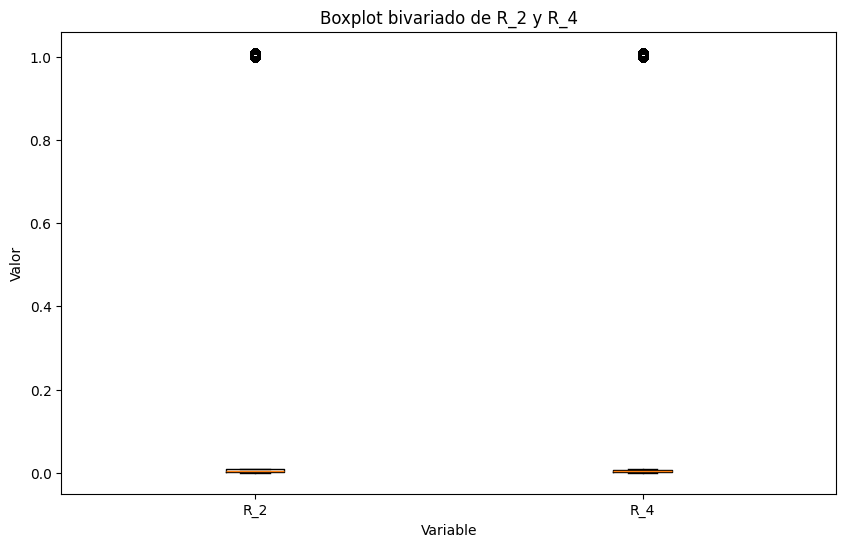

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot([train_data['R_2'], train_data['R_4']], tick_labels=['R_2', 'R_4'])
ax.set_title('Boxplot bivariado de R_2 y R_4')
ax.set_xlabel('Variable')
ax.set_ylabel('Valor')
plt.show()

Esta distribución en el boxplot también era esperada debido a la ausencia de valores intermedios en las gráficas superiores.

### `R_5` y `R_4`

In [12]:
train_data[['R_5', 'R_4']].describe()

R_5           R_4
count  5.531451e+06  5.531451e+06
mean   3.459403e-02  3.120413e-02
std    2.568067e-01  1.597703e-01
min    1.154589e-09  4.024685e-10
25%    2.575087e-03  2.565921e-03
50%    5.149018e-03  5.132659e-03
75%    7.721870e-03  7.700315e-03
max    3.500452e+01  1.010000e+00

La media de `R_5` es 0.0346, mientras que la de `R_4` es ligeramente inferior, de 0.0312. Las desviaciones estándar muestran que `R_5` tiene mayor dispersión (0.2568) en comparación con `R_4` (0.1598), lo que indica que los valores de `R_5` están más dispersos alrededor de su media. Los valores mínimos de ambas variables son extremadamente bajos, cercanos a cero, pero el valor máximo de `R_5` es extremadamente alto (35) comparado al 1.01 de `R_4`. En cuanto a los percentiles, el 25% de los datos se encuentra por debajo de 0.0026 en ambas columnas, el 50% (mediana) es de aproximadamente 0.0051, y el 75% se encuentra en torno a 0.0077, sugiriendo que la mayoría de los datos se agrupan en valores pequeños, salvo valores atípicos que se podrían encontrar en `R_5` debido a la diferencia entre el valor máximo y el percentil 75.

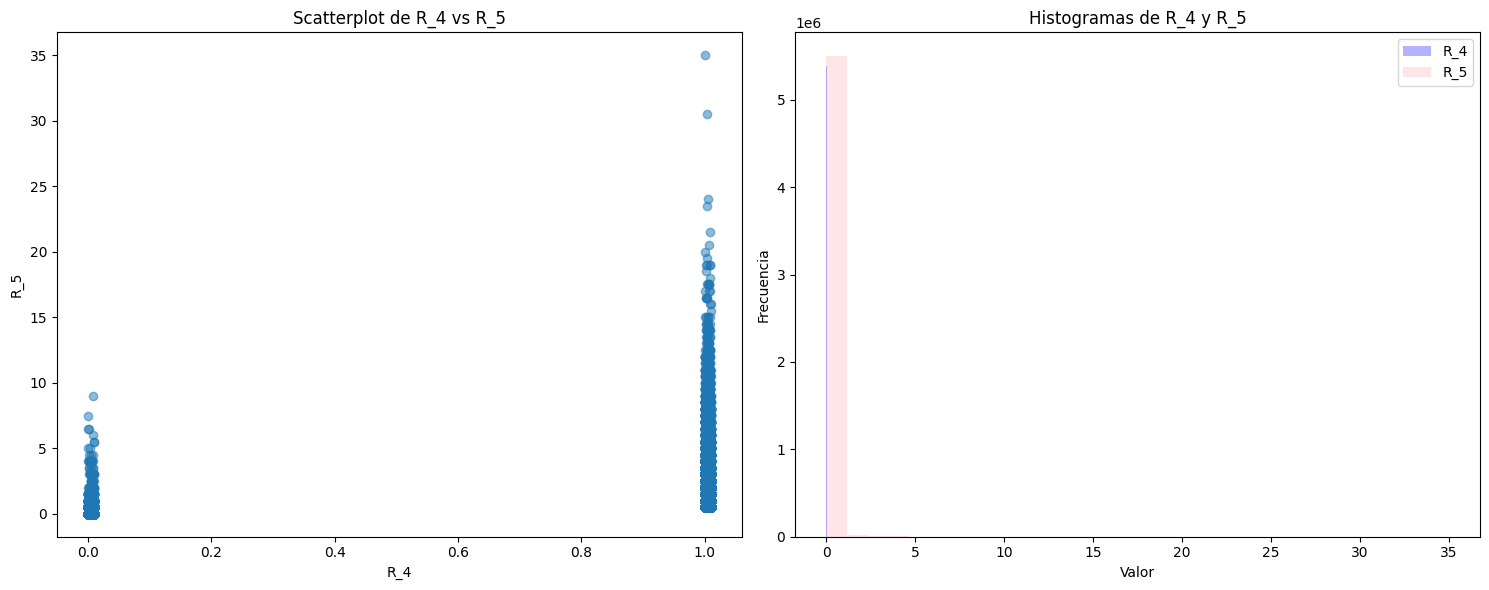

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(train_data['R_4'], train_data['R_5'], alpha=0.5)
ax1.set_title('Scatterplot de R_4 vs R_5')
ax1.set_xlabel('R_4')
ax1.set_ylabel('R_5')

ax2.hist(train_data['R_4'], bins=30, alpha=0.3, label='R_4', color='blue')
ax2.hist(train_data['R_5'], bins=30, alpha=0.1, label='R_5', color='red')
ax2.set_title('Histogramas de R_4 y R_5')
ax2.set_xlabel('Valor')
ax2.set_ylabel('Frecuencia')
ax2.legend()

plt.tight_layout()
plt.show()

Realizar un histograma acá no es de mucha utilidad debido a la gran diferencia entre los rangos de las variables, mientras `R_4` va de 0 a 1, `R_5` va de 0 a 35, por tanto no se puede apreciar nada. Lo mismo sucede en el boxplot. 

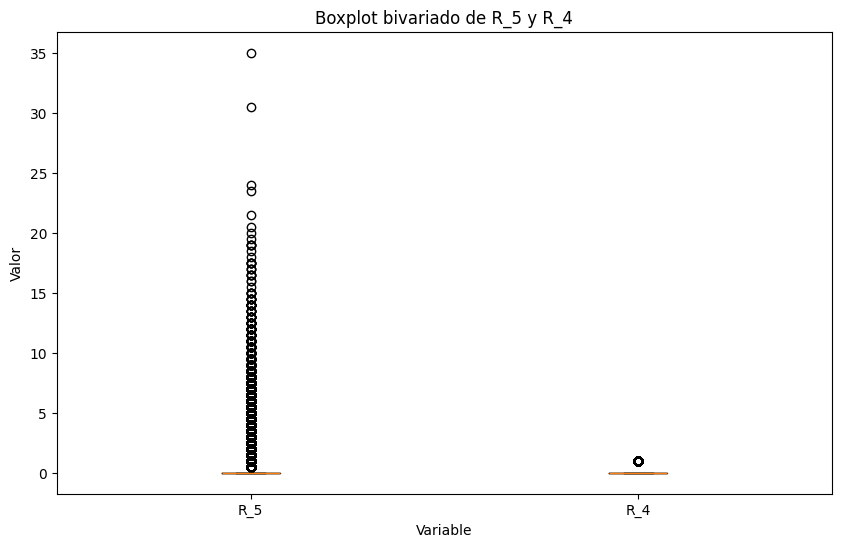

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot([train_data['R_5'], train_data['R_4']], tick_labels=['R_5', 'R_4'])
ax.set_title('Boxplot bivariado de R_5 y R_4')
ax.set_xlabel('Variable')
ax.set_ylabel('Valor')
plt.show()

Como s emencionaba, el análisis bivariado por boxplot no es un buen abordamiento debido a la presencia de valores extremos en una de las variables, `R_5`, los valores atípicos en `R_4` corresponden a aquellos cercanos a 1 que toma como atípicos.

# Tratamientos de datos faltantes y multicolinealidad

Variables delincuenciales: 96 - ['D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_63', 'D_64', 'D_65', 'D_66', 'D_68', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 'D_83', 'D_84', 'D_86', 'D_87', 'D_88', 'D_89', 'D_91', 'D_92', 'D_93', 'D_94', 'D_96', 'D_102', 'D_103', 'D_104', 'D_105', 'D_106', 'D_107', 'D_108', 'D_109', 'D_110', 'D_111', 'D_112', 'D_113', 'D_114', 'D_115', 'D_116', 'D_117', 'D_118', 'D_119', 'D_120', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_127', 'D_128', 'D_129', 'D_130', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143', 'D_144', 'D_145']
Variables de gastos: 22 - ['S_2', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_17', 'S_18', 'S_19', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27']
Variables de pagos: 3 - ['P_2', 'P_3', 'P_4']
Variables de balance: 40 - ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_26', 'B_27', 'B_28', 'B_29', 'B_30', 'B_31', 'B_32', 'B_33', 'B_36', 'B_37', 'B_38', 'B_39', 'B_40', 'B_41', 'B_42']
Variables de riesgo: 28 - ['R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_12', 'R_13', 'R_14', 'R_15', 'R_16', 'R_17', 'R_18', 'R_19', 'R_20', 'R_21', 'R_22', 'R_23', 'R_24', 'R_25', 'R_26', 'R_27', 'R_28']

<Axes: >

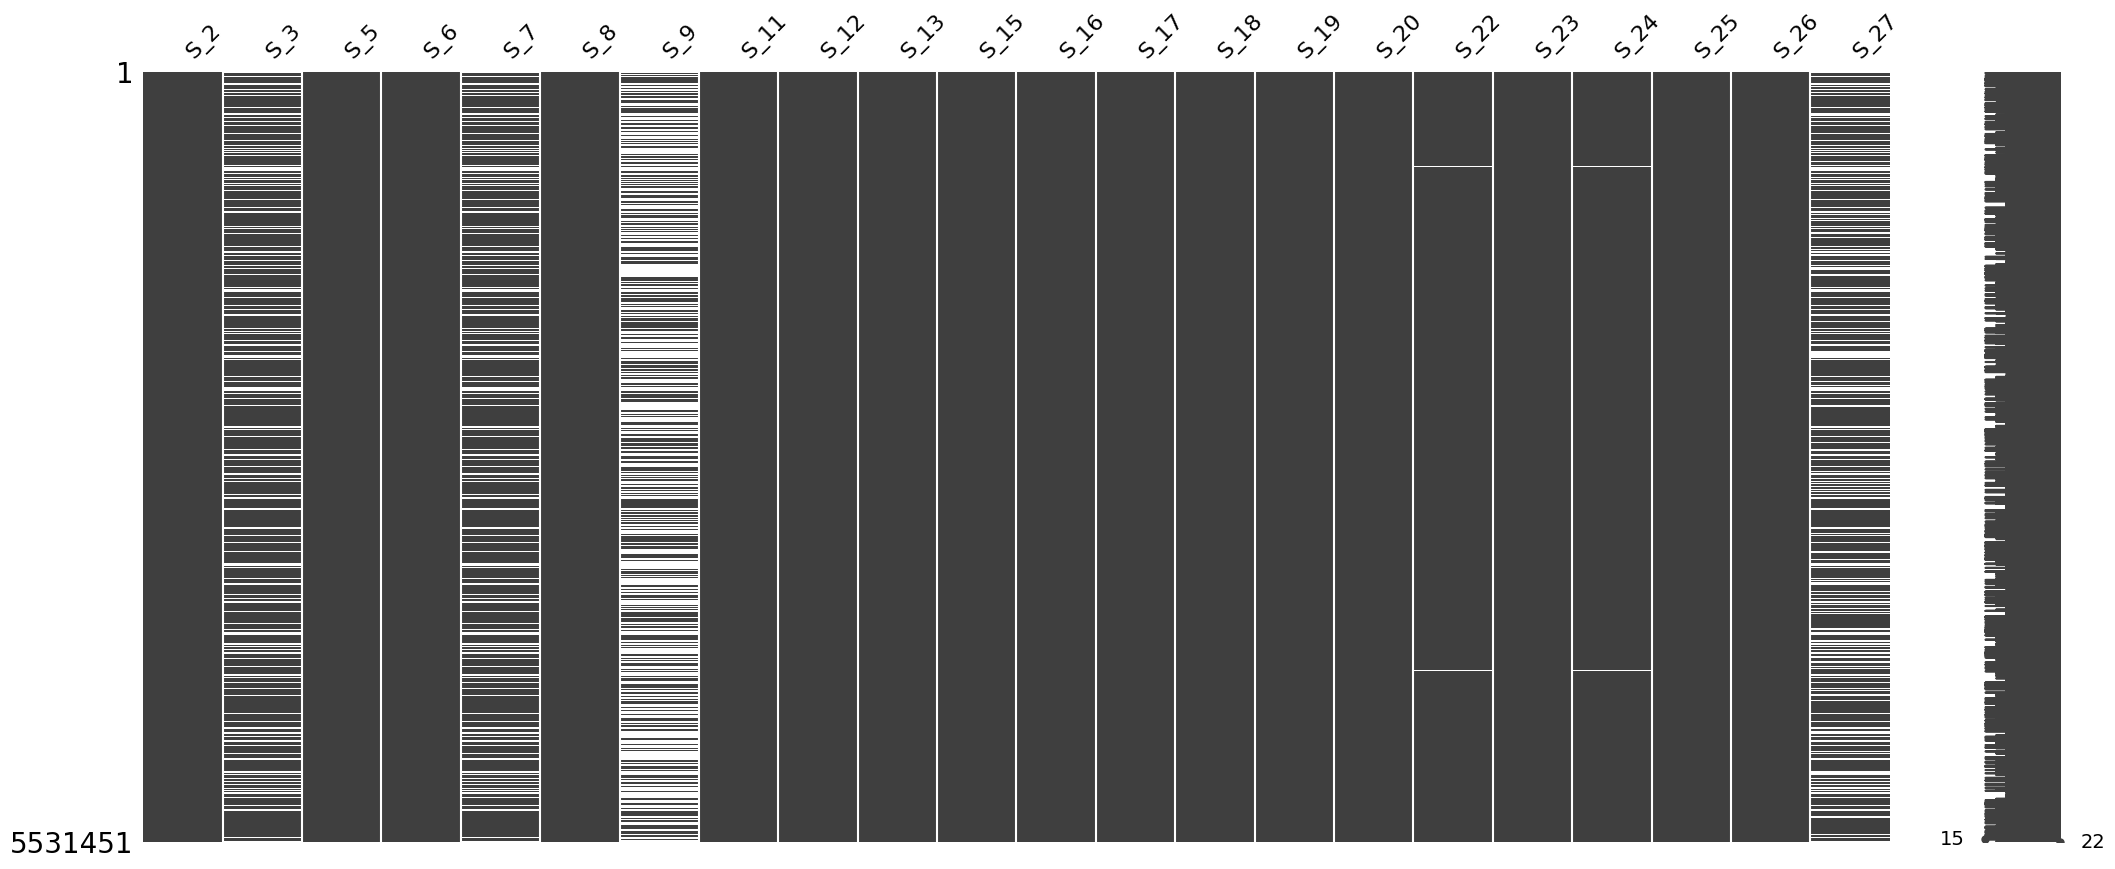

In [74]:
msno.matrix(train_data[['S_2', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_17', 'S_18', 'S_19', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27']])

En seis variables de gastos hay valores nulos. Parece que los datos faltantes en `S_3` y  `S_7` correspoden a los mismos registros, revisemos esto.

In [75]:
(train_data['S_3'].isnull() != train_data['S_7'].isnull()).sum()

np.int64(0)

En efecto, dado que la suma de registros con valores distintos es 0, ambas variables comparten los mismos datos nulos.

<Axes: >

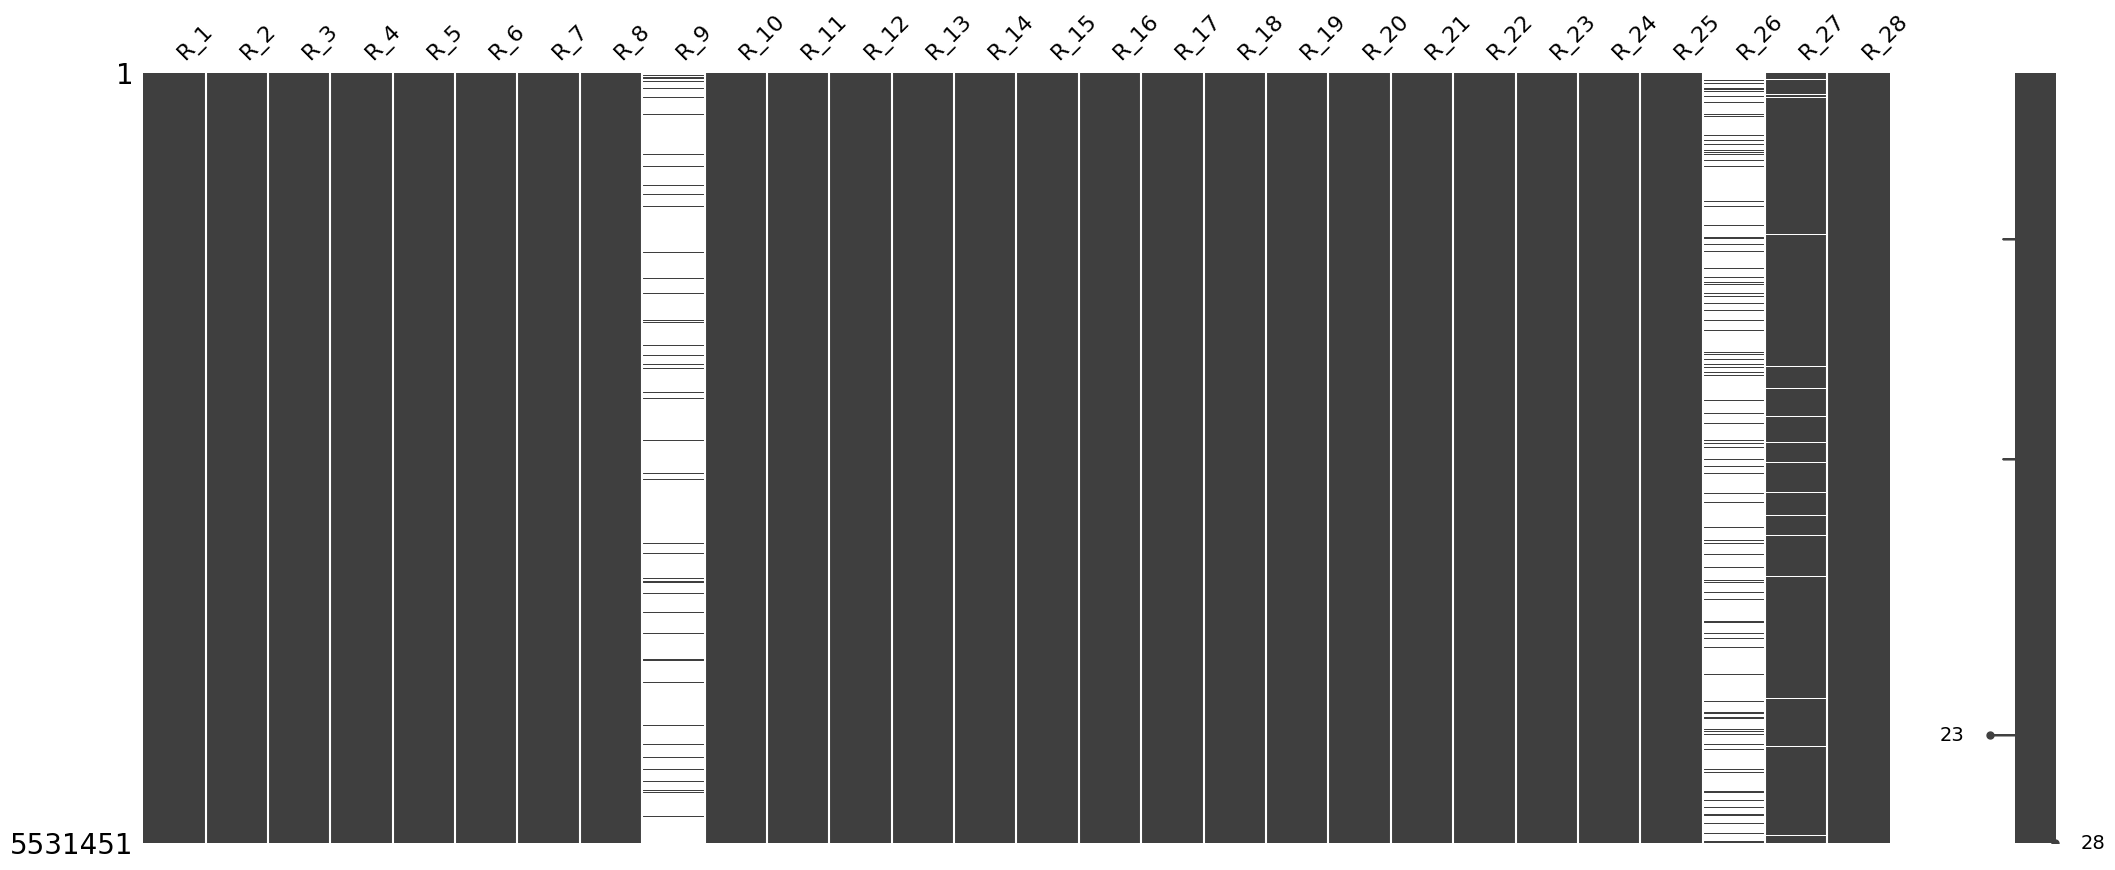

In [76]:
msno.matrix(train_data[['R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_12', 'R_13', 'R_14', 'R_15', 'R_16', 'R_17', 'R_18', 'R_19', 'R_20', 'R_21', 'R_22', 'R_23', 'R_24', 'R_25', 'R_26', 'R_27', 'R_28']])

3 valores de riesgo cuentan con valores nulos, no se nota una conexión entre los valores faltantes. LLama la atención como `R_9` y `R_26` poseen en su gran mayoría datos faltantes, teniendo poco registros válidos.

<Axes: >

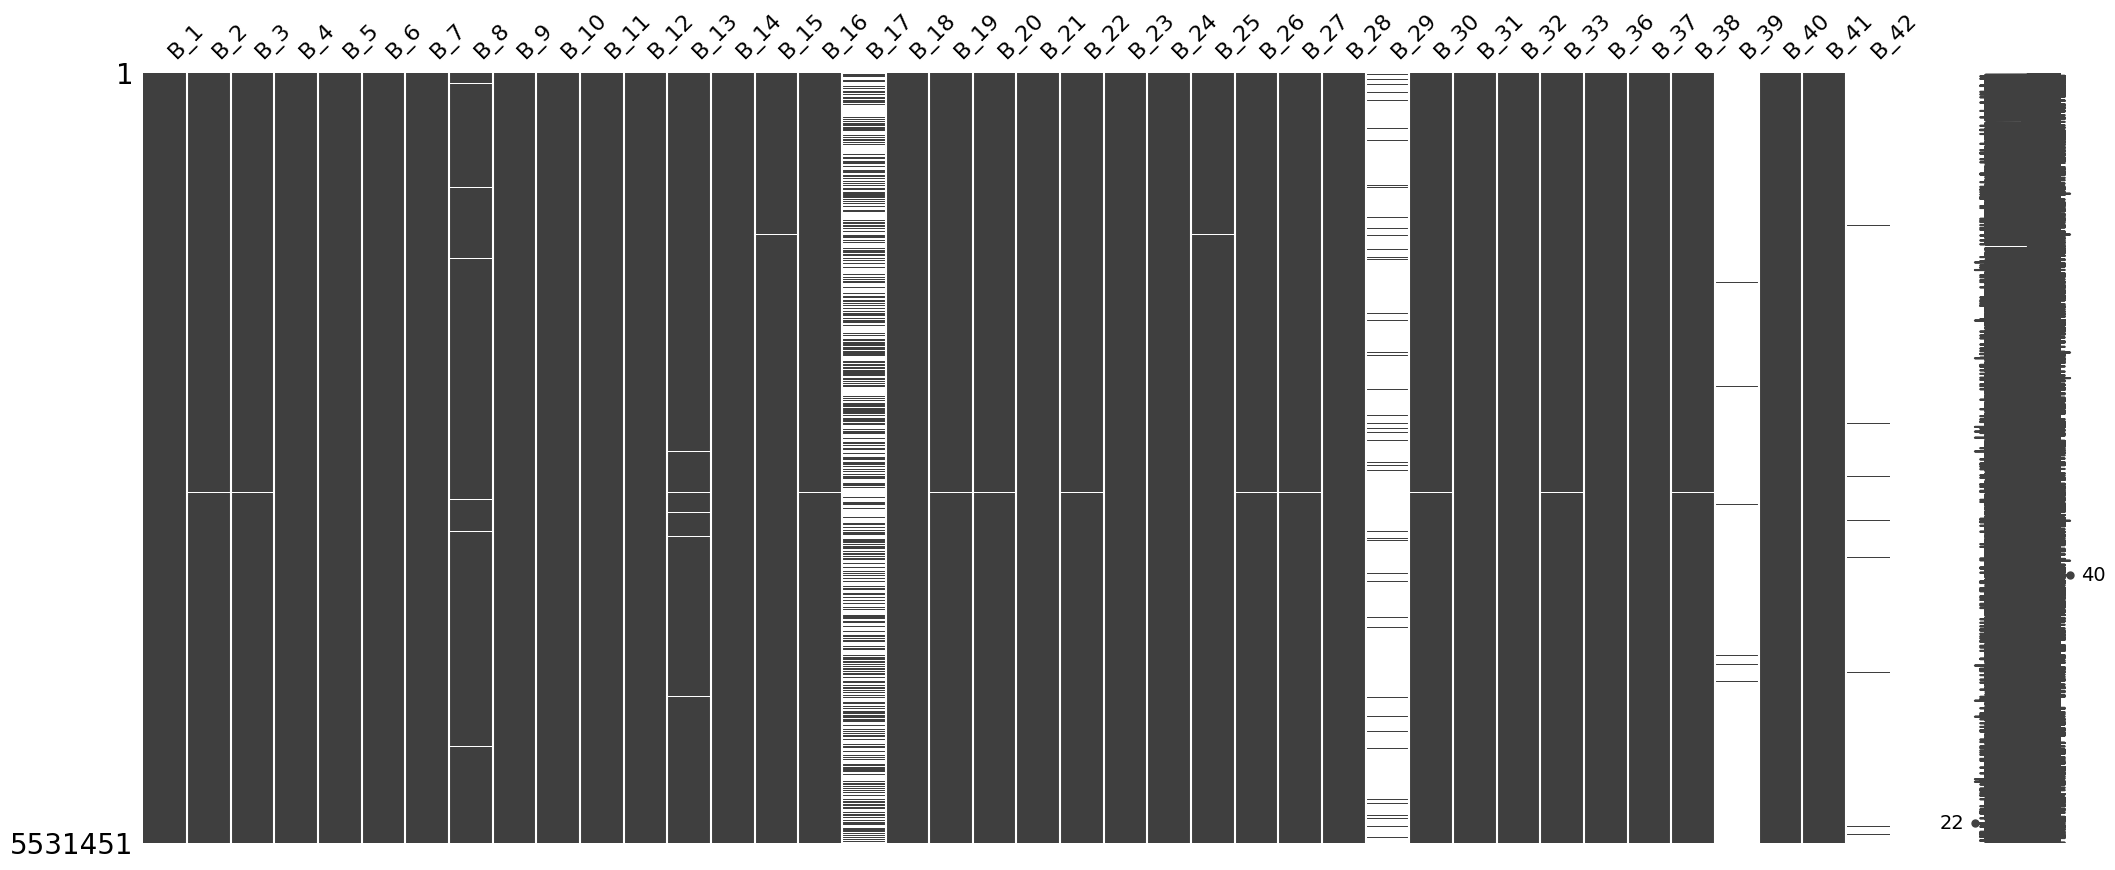

In [77]:
msno.matrix(train_data[['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_26', 'B_27', 'B_28', 'B_29', 'B_30', 'B_31', 'B_32', 'B_33', 'B_36', 'B_37', 'B_38', 'B_39', 'B_40', 'B_41', 'B_42']])

Variables como `B_17`, `B_29`, `B_39` y `B_42` en su mayoría son registros nulos.

In [78]:
((train_data['B_22'].isnull() != train_data['B_16'].isnull()) != train_data['B_19'].isnull()).sum()

np.int64(2016)

Parece suceder algo similar que con el grupo anterior de variables y es que `B_16`, `B_19`, `B_20`, `B_22`, `B_26`, `B_27`, `B_30`, `B_33` y `B_38` parecen compartir los mismos datos faltantes.

<Axes: >

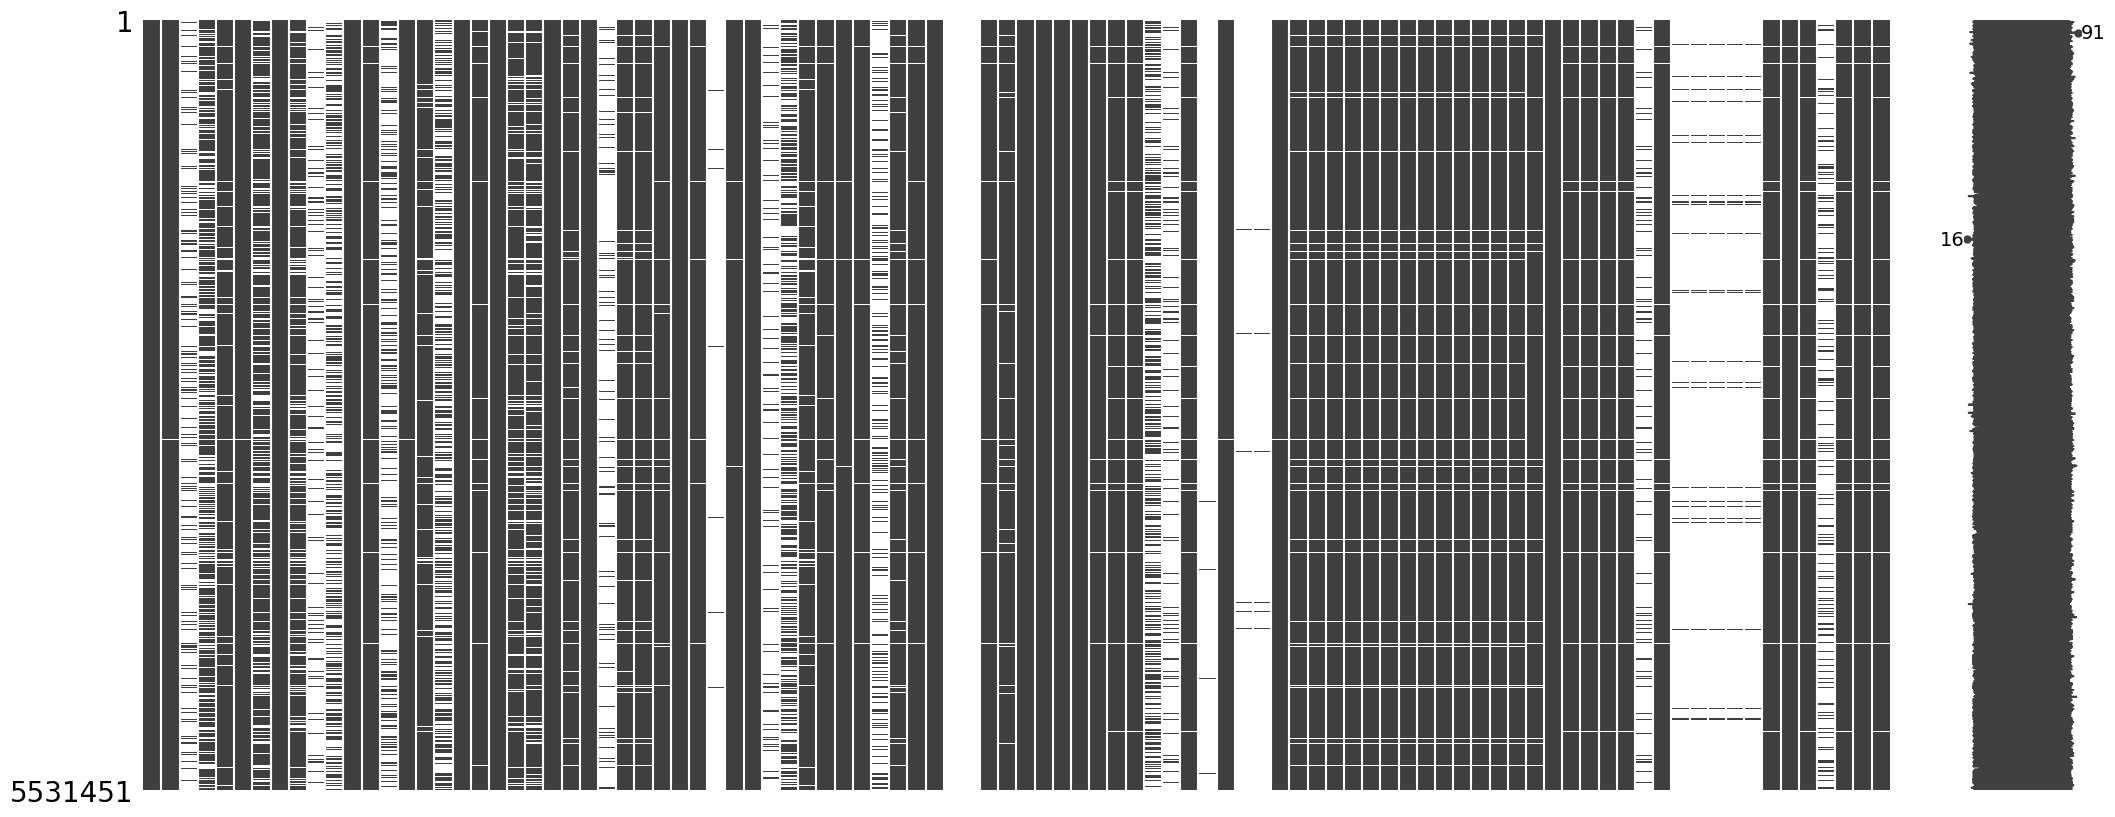

In [79]:
msno.matrix(train_data[['D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_63', 'D_64', 'D_65', 'D_66', 'D_68', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 'D_83', 'D_84', 'D_86', 'D_87', 'D_88', 'D_89', 'D_91', 'D_92', 'D_93', 'D_94', 'D_96', 'D_102', 'D_103', 'D_104', 'D_105', 'D_106', 'D_107', 'D_108', 'D_109', 'D_110', 'D_111', 'D_112', 'D_113', 'D_114', 'D_115', 'D_116', 'D_117', 'D_118', 'D_119', 'D_120', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_127', 'D_128', 'D_129', 'D_130', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143', 'D_144', 'D_145']])

Dada la gran cantidad de variables asociadas a delincuencia no se puden apreciar las etiquetas de cada una de ellas, pero sigue sucediendo que en varias variables se encuentran los mismos registros con datos faltantes como en las 13 variables que se encuentran juntas (*Bloque 3.*) o el conjunto de seis variables separadas por una variable que tienen el mismo comportamiento de datos faltantes (*Bloque 4.*)

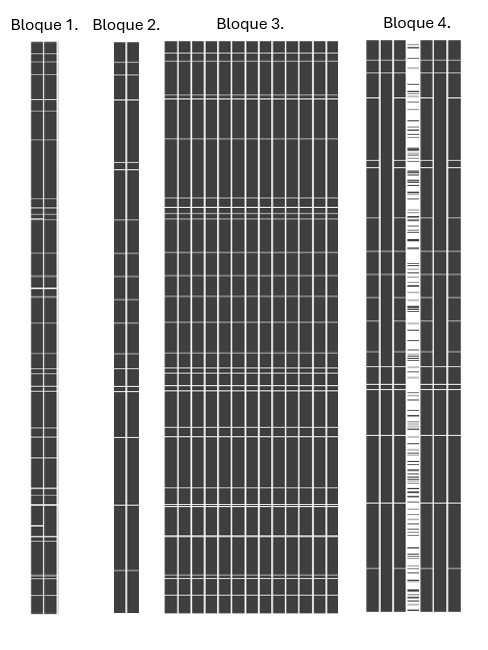

<Axes: >

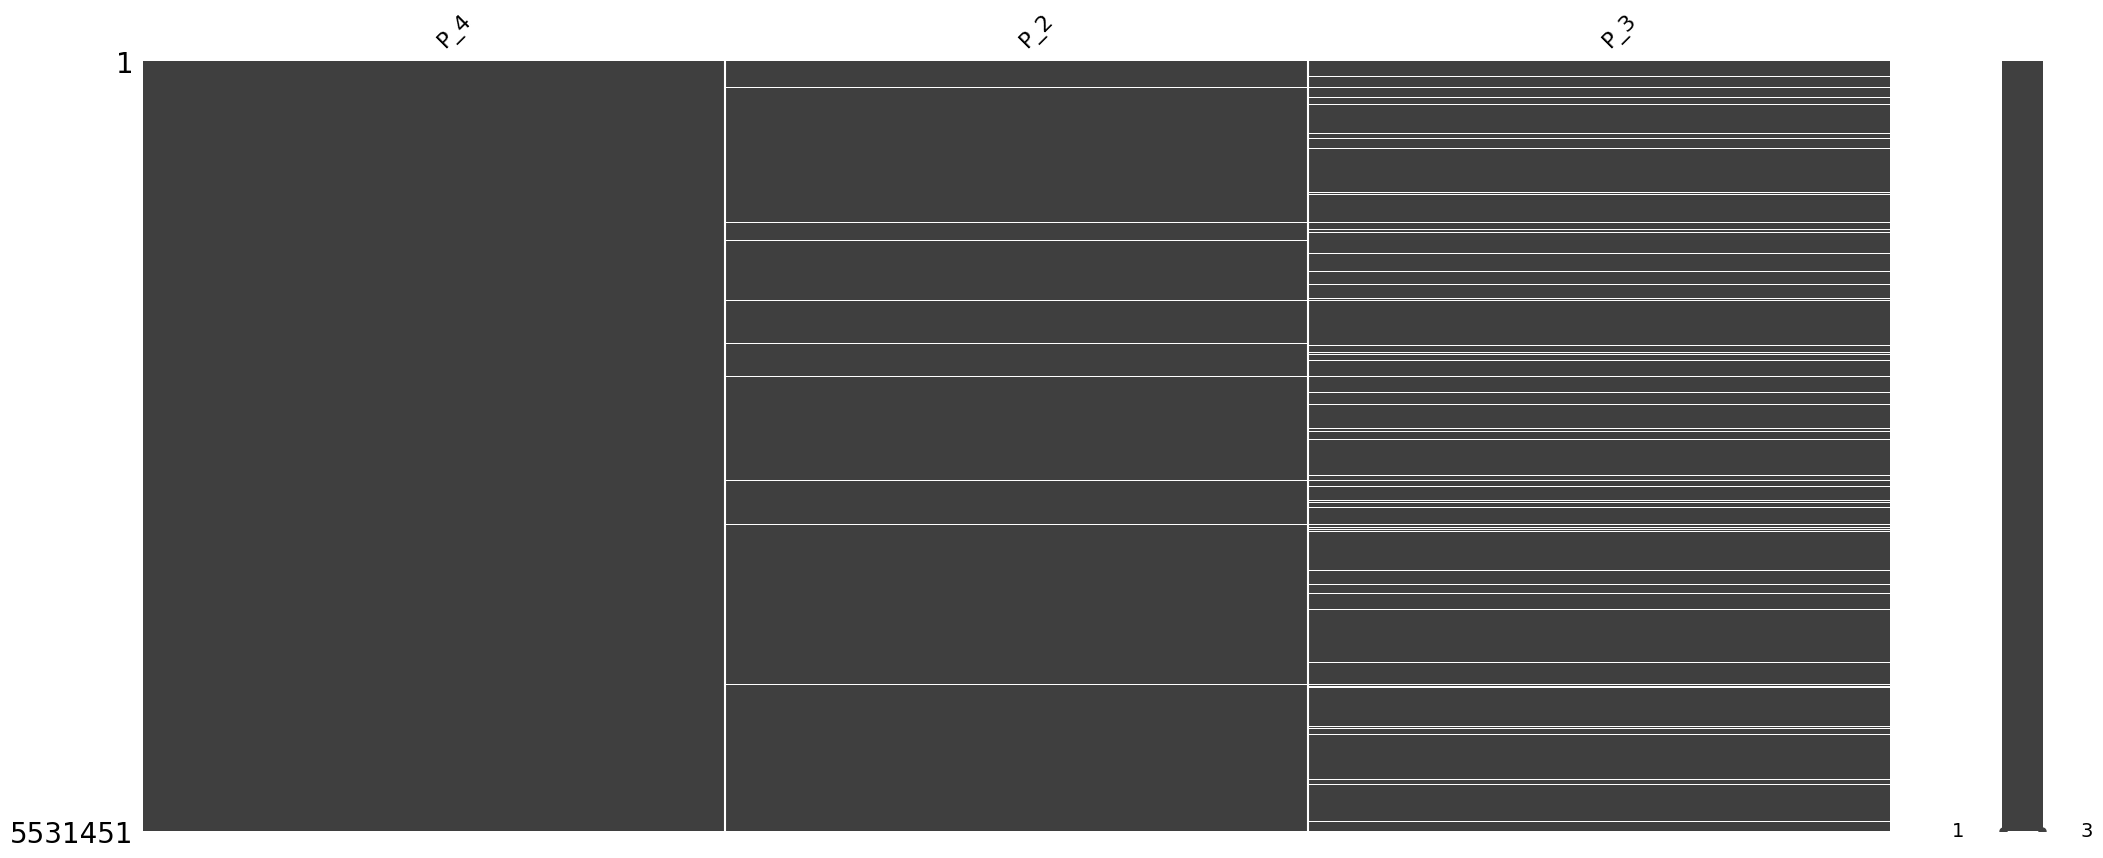

In [80]:
msno.matrix(train_data[['P_4','P_2','P_3']])

Aquí la cantidad de datos faltantes por variable no es tan grande y no parece haber una relación entre los datos faltantes de ``P_2` y `P_3`

Debido a la gran cantidad de variables con un alto porcentaje de datos faltantes, de decidió eliminar aquellas con un porcentaje de datos faltantes mayor a 50%

In [81]:
missing_per = pd.DataFrame(fa.missing_per(train_data))
show = missing_per[missing_per > 50].dropna()
show

0
D_42   85.694278
D_49   90.137597
D_50   56.809723
D_53   73.842921
D_56   54.071581
S_9    53.035686
B_17   56.722874
D_66   88.730733
D_73   98.990211
D_76   88.746226
R_9    94.349891
D_82   73.373406
B_29   93.104594
D_87   99.930127
D_88   99.891457
D_105  54.622756
D_106  90.213255
R_26   88.984717
D_108  99.476846
D_110  99.433530
D_111  99.433530
B_39   99.391986
B_42   98.707789
D_132  90.191055
D_134  96.480146
D_135  96.480146
D_136  96.480146
D_137  96.480146
D_138  96.480146
D_142  82.926577

In [82]:
len(show)

30

In [83]:
show.index

Index(['D_42', 'D_49', 'D_50', 'D_53', 'D_56', 'S_9', 'B_17', 'D_66', 'D_73',
       'D_76', 'R_9', 'D_82', 'B_29', 'D_87', 'D_88', 'D_105', 'D_106', 'R_26',
       'D_108', 'D_110', 'D_111', 'B_39', 'B_42', 'D_132', 'D_134', 'D_135',
       'D_136', 'D_137', 'D_138', 'D_142'],
      dtype='object')

En total son 30 variables y en su mayoría corresponden a variables asociadas a delincuencia.

In [18]:
td = train_data.drop(columns = ['D_42', 'D_49', 'D_50', 'D_53', 'D_56', 'S_9', 'B_17', 'D_66', 'D_73',
       'D_76', 'R_9', 'D_82', 'B_29', 'D_87', 'D_88', 'D_105', 'D_106', 'R_26',
       'D_108', 'D_110', 'D_111', 'B_39', 'B_42', 'D_132', 'D_134', 'D_135',
       'D_136', 'D_137', 'D_138', 'D_142'])

In [19]:
td.head()

customer_ID         S_2       P_2  \
0  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-03-09  0.938469   
1  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-04-07  0.936665   
2  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-05-28  0.954180   
3  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-06-13  0.960384   
4  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-07-16  0.947248   

       D_39       B_1       B_2       R_1       S_3      D_41       B_3  ...  \
0  0.001733  0.008724  1.006838  0.009228  0.124035  0.008771  0.004709  ...   
1  0.005775  0.004923  1.000653  0.006151  0.126750  0.000798  0.002714  ...   
2  0.091505  0.021655  1.009672  0.006815  0.123977  0.007598  0.009423  ...   
3  0.002455  0.013683  1.002700  0.001373  0.117169  0.000685  0.005531  ...   
4  0.002483  0.015193  1.000727  0.007605  0.117325  0.004653  0.009312  ...   

      D_130     D_131     D_133      R_28     D_139     D_140     D_141  \
0  0.002052  0.005972  0.004345  0.001535  0.002427  0.003706  0.003818   
1  0.001034  0.004838  0.007495  0.004931  0.003954  0.003167  0.005032   
2  0.005681  0.005497  0.009227  0.009123  0.003269  0.007329  0.000427   
3  0.007108  0.008261  0.007206  0.002409  0.006117  0.004516  0.003200   
4  0.009680  0.004848  0.006312  0.004462  0.003671  0.004946  0.008889   

      D_143     D_144     D_145  
0  0.000569  0.000610  0.002674  
1  0.009576  0.005492  0.009217  
2  0.003429  0.006986  0.002603  
3  0.008419  0.006527  0.009600  
4  0.001670  0.008126  0.009827  

[5 rows x 160 columns]

Ahora contamos con 160 variables en las cuales hay valores faltantes en 92 de ellas.

In [26]:
missing_per = pd.DataFrame(fa.missing_per(td))
show = missing_per[missing_per > 0].dropna()
show

0
P_2     0.831337
B_2     0.036446
S_3    18.449843
D_41    0.036446
B_3     0.036446
...          ...
D_140   0.734563
D_141   1.835829
D_143   1.835829
D_144   0.736281
D_145   1.835829

[92 rows x 1 columns]

In [ ]:
numeric_cols.to_list()

En una maquina virtual se realizó el proceso de imputación de datos usando IterativeImputer() para las variables numéricas, guardado en un pickle sobre el cual, debido al bajo procentaje de datos faltantes en variables categóricas se decidió imputar con la mediana y luego se le aplicó la prueba de contingencia de chi cuadrado, para posteriormente realizar la reducción de multicolinealidad con PCA pasando de 160 a 64 variables significativas. Se muestra a continuación el resultado obtenido de este proceso de limpieza al igual que las respectivas salidas en algunos de los procesos. 

![Imagen de WhatsApp 2024-10-21 a las 10.28.12_fd966ce3.jpg](<attachment:Imagen de WhatsApp 2024-10-21 a las 10.28.12_fd966ce3.jpg>)
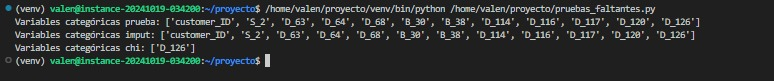

La reducción de multicolinealidad con PCA se realizó basándose en las cargas de las variables, aquellas que sobrepasar un threshold de 0.35 se consideraron significativas.

![Imagen de WhatsApp 2024-10-21 a las 10.18.58_624980a3.jpg](<attachment:Imagen de WhatsApp 2024-10-21 a las 10.18.58_624980a3.jpg>)
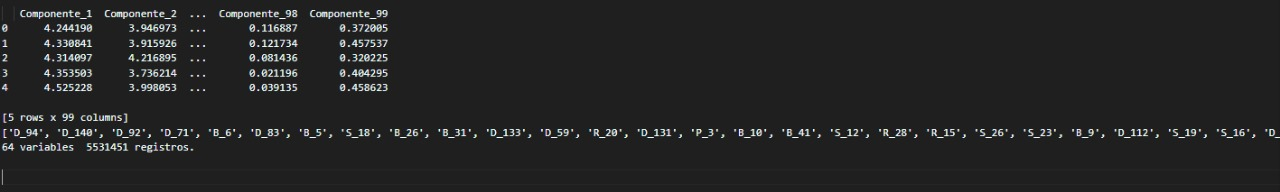

Se muestran también los encabezados de la base de datos a medida que se fue avanzando en cada proceso. 

In [ ]:
# Código utilizado para imputar
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import dask.dataframe as dd

td = pd.read_pickle("td.pkl")
print(td.head())
tdp = td.select_dtypes(include=['number'])
tdpd = dd.from_pandas(tdp, npartitions=32)

def ip(df_partition):
    nnc = df_partition.columns[df_partition.notnull().any()]
    if len(nnc) == 0:
        return df_partition
    imputer = IterativeImputer(max_iter=7)
    return pd.DataFrame(imputer.fit_transform(df_partition[nnc]), columns=nnc)

imputed_ddf = tdpd.map_partitions(ip)
imputed_ddf = imputed_ddf.compute()

print(td.info())
print(imputed_ddf.info())
print(tdp.columns.tolist())

tnn = td.drop(columns=tdp.columns)
td_non_numeric = tnn.reset_index(drop=True)
imputed_ddf = imputed_ddf.reset_index(drop=True)

td_final = pd.concat([td_non_numeric, imputed_ddf], axis=1)

print(td_final.info())
print(td_final)

td_final.to_pickle('td_imputed.pkl')

In [5]:
# Imputación
pd.read_pickle("imput_head.pkl")

customer_ID         S_2 D_63 D_64  \
0  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-03-09   CR    O   
1  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-04-07   CR    O   
2  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-05-28   CR    O   
3  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-06-13   CR    O   
4  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-07-16   CR    O   

  D_68 B_30 B_38 D_114 D_116 D_117  ...     D_130     D_131     D_133  \
0  6.0  0.0  2.0   1.0   0.0   4.0  ...  0.002052  0.005972  0.004345   
1  6.0  0.0  2.0   1.0   0.0   4.0  ...  0.001034  0.004838  0.007495   
2  6.0  0.0  2.0   1.0   0.0   4.0  ...  0.005681  0.005497  0.009227   
3  6.0  0.0  2.0   1.0   0.0   4.0  ...  0.007108  0.008261  0.007206   
4  6.0  0.0  2.0   1.0   0.0   4.0  ...  0.009680  0.004848  0.006312   

       R_28     D_139     D_140     D_141     D_143     D_144     D_145  
0  0.001535  0.002427  0.003706  0.003818  0.000569  0.000610  0.002674  
1  0.004931  0.003954  0.003167  0.005032  0.009576  0.005492  0.009217  
2  0.009123  0.003269  0.007329  0.000427  0.003429  0.006986  0.002603  
3  0.002409  0.006117  0.004516  0.003200  0.008419  0.006527  0.009600  
4  0.004462  0.003671  0.004946  0.008889  0.001670  0.008126  0.009827  

[5 rows x 160 columns]

In [ ]:
# Código utilizado para imputar categóricas y chi cuadrado
import pandas as pd
from scipy.stats import chi2_contingency

td = pd.read_pickle("td_imputed.pkl")

cvars = td.select_dtypes(include=['object', 'category']).columns

for column in cvars:
    mode_value = td[column].mode()[0] 
    td[column].fillna(mode_value, inplace=True)

print(td)
results = []

for i in range(len(cvars)):
    for j in range(i + 1, len(cvars)):
        var1 = cvars[i]
        var2 = cvars[j]
        
        contingency_table = pd.crosstab(td[var1], td[var2])

        chi2, p, dof, expected = chi2_contingency(contingency_table)
        
        results.append({
            'Variable 1': var1,
            'Variable 2': var2,
            'Chi2 Statistic': chi2,
            'p-value': p
        })

results = pd.DataFrame(results)

print("Resultados del test Chi-cuadrado:")
print(results)

hc = results[results['p-value'] < 0.05]
print('A eliminar por chi2', hc)

vtd = hc['Variable 1'].unique()

td = td.drop(columns=vtd, errors='ignore')

td.to_pickle('td_cleanedchi2.pkl')


In [6]:
# Imputación categórica y chi cuadrado
pd.read_pickle("chi_head.pkl")

D_126       P_2      D_39       B_1       B_2       R_1       S_3      D_41  \
0   1.0  0.938469  0.001733  0.008724  1.006838  0.009228  0.124035  0.008771   
1   1.0  0.936665  0.005775  0.004923  1.000653  0.006151  0.126750  0.000798   
2   1.0  0.954180  0.091505  0.021655  1.009672  0.006815  0.123977  0.007598   
3   1.0  0.960384  0.002455  0.013683  1.002700  0.001373  0.117169  0.000685   
4   1.0  0.947248  0.002483  0.015193  1.000727  0.007605  0.117325  0.004653   

        B_3      D_43  ...     D_130     D_131     D_133      R_28     D_139  \
0  0.004709  0.044116  ...  0.002052  0.005972  0.004345  0.001535  0.002427   
1  0.002714  0.045111  ...  0.001034  0.004838  0.007495  0.004931  0.003954   
2  0.009423  0.045342  ...  0.005681  0.005497  0.009227  0.009123  0.003269   
3  0.005531  0.050301  ...  0.007108  0.008261  0.007206  0.002409  0.006117   
4  0.009312  0.036697  ...  0.009680  0.004848  0.006312  0.004462  0.003671   

      D_140     D_141     D_143     D_144     D_145  
0  0.003706  0.003818  0.000569  0.000610  0.002674  
1  0.003167  0.005032  0.009576  0.005492  0.009217  
2  0.007329  0.000427  0.003429  0.006986  0.002603  
3  0.004516  0.003200  0.008419  0.006527  0.009600  
4  0.004946  0.008889  0.001670  0.008126  0.009827  

[5 rows x 149 columns]

El resultado se encuentra un pickle llamado 'td_cleanedchi2pca.pkl'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df = pd.read_pickle("td_cleanedchi2.pkl")
dn = df.select_dtypes(include=[np.number])
scaler = StandardScaler()
datosnor = scaler.fit_transform(dn)

modelo_pca = PCA(n_components=0.95)
cp = modelo_pca.fit_transform(datosnor)

df_componentes_principales = pd.DataFrame(data=cp, 
                                           columns=[f'Componente_{i+1}' for i in range(cp.shape[1])])

print(df_componentes_principales.head())

cargas_componentes = modelo_pca.components_
df_cargas = pd.DataFrame(cargas_componentes, columns=dn.columns, 
                         index=[f'Componente_{i+1}' for i in range(cargas_componentes.shape[0])])

ts = 0.38

variables_significativas = set()
for i in range(df_cargas.shape[0]):
    variables = df_cargas.columns[np.abs(df_cargas.iloc[i]) > ts]
    variables_significativas.update(variables)

df_pca = df[list(variables_significativas)]

df_pca.to_pickle("td_cleanedchi2pca.pkl")

In [3]:
# Reducción de multicolinealidad por PCA
td = pd.read_pickle("td_cleanedchi2pca.pkl")

In [4]:
td.head()

D_94     D_140      D_92      D_71       B_6      D_83       B_5  \
0  0.008871  0.003706  1.006133  0.119403  0.063902  0.007043  0.170600   
1  0.000391  0.003167  1.005791  0.140611  0.065261  0.007789  0.113239   
2  0.009234  0.007329  1.005801  0.075868  0.066982  0.004093  0.060492   
3  0.003200  0.004516  1.007036  0.150209  0.083720  0.008817  0.166782   
4  0.003845  0.004946  1.002915  0.096441  0.075900  0.001845  0.143630   

       S_18      B_26  B_31  ...      R_17      D_96       S_6      R_22  \
0  0.005720  0.000272   1.0  ...  0.000198  0.004950  0.008322  0.007479   
1  0.007584  0.000979   1.0  ...  0.001142  0.003180  0.002482  0.006827   
2  0.005901  0.006149   1.0  ...  0.008013  0.005433  0.000530  0.009820   
3  0.002520  0.009193   1.0  ...  0.009455  0.000063  0.000783  0.000458   
4  0.000155  0.005738   1.0  ...  0.002019  0.000535  0.006698  0.003341   

       B_24      R_23      S_11      R_12      D_86     D_123  
0  0.004327  0.006893  0.401619  1.009825  0.007084  0.003057  
1  0.004203  0.002837  0.406326  1.009461  0.006677  0.001306  
2  0.001782  0.005080  0.406768  1.004291  0.001185  0.003954  
3  0.005595  0.007320  0.405175  1.004728  0.003324  0.005135  
4  0.004933  0.000264  0.487460  1.000904  0.001504  0.002849  

[5 rows x 64 columns]

Nótese que la variable customer_id fue eliminada, sin embargo, debido a la construcción del modelo será reagregada a los datos. 

In [4]:
customer_id = pd.read_pickle('td.pkl')

In [5]:
td['customer_ID'] = customer_id['customer_ID']

In [6]:
customer_id = pd.read_csv('train_labels.csv')

In [7]:
merged = td.merge(customer_id[['customer_ID', 'target']], on='customer_ID', how='left')

In [8]:
data = merged

# Modelos

Considere el conjunto de datos **Default Probability Prediction**. Implemente la versión de clasificación para cada uno de los modelos estudiados en clases, y prediga la variable respuesta, probabilidad para la variable target (default probability). Construir una tabla de error que contenga las métricas usuales de clasificación: precision, recall, f1-score, AUC. Además, agregue matrices de confusión (ver `confusion_matrix`) y curvas ROC (ver `plot_roc`). Inicialmente realice un balanceo de clases usando **ADASYN** (Adaptive Synthetic Sampling), luego compare los resultados predictivos con o sin balanceo ADASYN. Posteriormente, realice hiperparametrización usando **BayesianOptimization**, **GridSearchCV**, y **Pipeline** para evaluar cada modelo, y compare los resultados en términos de tiempo de computo. Verifique que la validación cruzada seleccionada es la adecuada, y justifíquelo. 

## ¿Qué es ADASYN?

ADASYN (Adaptive Synthetic Sampling) es una técnica de sobremuestreo utilizada para abordar problemas de desbalanceo en conjuntos de datos, especialmente en problemas de clasificación donde una clase es significativamente menos representada que otra. Se generan instancias sintéticas para las instancias difíciles, donde la cantidad de instancias a generar se determina por el nivel de dificultad. Para cada instancia seleccionada, se eligen aleatoriamente vecinos cercanos de la clase mayoritaria para crear nuevos puntos sintéticos en el espacio de características.

In [2]:
import pandas as pd
import numpy as np

from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pickle

Todos los modelos, de igual manera fueron ejecutados en una máquina virtual. Se presentan los códigos utilizados y posteriormente la importación de los pickles asociados a los modelos ya entrenados.

In [9]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    print("Precisión:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("AUC:", auc)
    print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
    


Previo a la construcción de los modelos, se modificó la base de datos luego de la limpieza para agregar nuevamente la columna 'customer_ID', necesaria para asociar a los clientes y sus registros dentro de los modelos.


## Modelos sin ADASYN

In [14]:
tabla = {
    'Precisión': [0.76, 0.61, 0.73, 0.73],
    'Recall': [0.71, 0.5, 0.57, 0.59],
    'f1': [0.75, 0.55, 0.64, 0.65],
    'AUC': [0.91, 0.84, 0.89, 0.89]
}

tabla = pd.DataFrame(tabla, index=['KNN', 'Clasificación bayesiana', 'Penalización L1', 'Penalización L2'])


In [ ]:
X = data.drop(columns=['target', 'customer_ID'])
cat_cols = X.select_dtypes(include=['object', 'category']).columns
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=10, stratify=y)


### KNN

In [ ]:
knn_no_balanceo = KNeighborsClassifier(n_neighbors=5)
knn_no_balanceo.fit(X_train, y_train)
with open('knn_no_balanceo.pkl', 'wb') as f:
    pickle.dump(knn_no_balanceo, f)

In [15]:
knnnb = pd.read_pickle('modelos/knn_no_balanceo.pkl')

In [ ]:
evaluate_model(knnnb, X_test, y_test)

Este modelo fue entrenado con todos los datos del conjunto de entrenamiento y se obtuvieron las siguientes métricas:

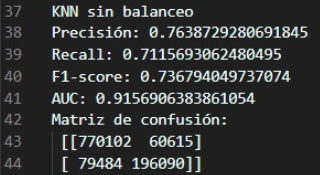

In [21]:
pd.DataFrame(tabla.loc['KNN']).T

Precisión  Recall    f1   AUC
KNN       0.76    0.71  0.75  0.91

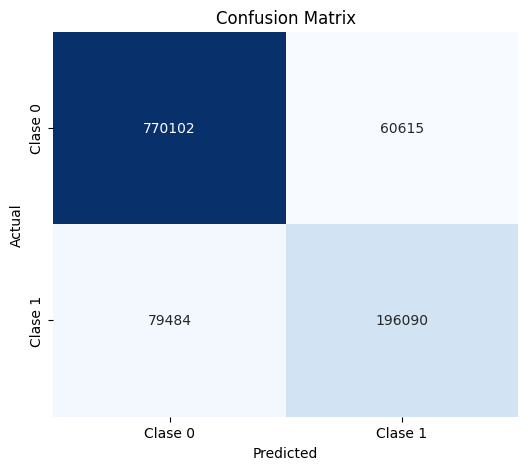

In [11]:
conf_matrix = np.array([[770102, 60615],
                        [79484, 196090]])
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["Clase 0", "Clase 1"], 
            yticklabels=["Clase 0", "Clase 1"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

El modelo predijo correctamente la clase positiva en 770,102 casos y predijo correctamente la clase negativa en 196,090 casos.

### Clasificación bayesiana

In [ ]:
nb_no_balanceo = GaussianNB()
nb_no_balanceo.fit(X_train, y_train)
evaluate_model(nb_no_balanceo, X_test, y_test)
with open('nb_no_balanceo.pkl', 'wb') as f:
    pickle.dump(nb_no_balanceo, f)

In [ ]:
nbnb = pd.read_pickle('modelos/nb_no_balanceo.pkl')

In [ ]:
evaluate_model(nbnb, X_test, y_test)

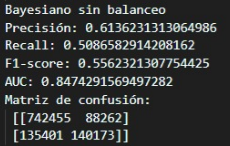

In [22]:
pd.DataFrame(tabla.loc['Clasificación bayesiana']).T

Precisión  Recall    f1   AUC
Clasificación bayesiana       0.61     0.5  0.55  0.84

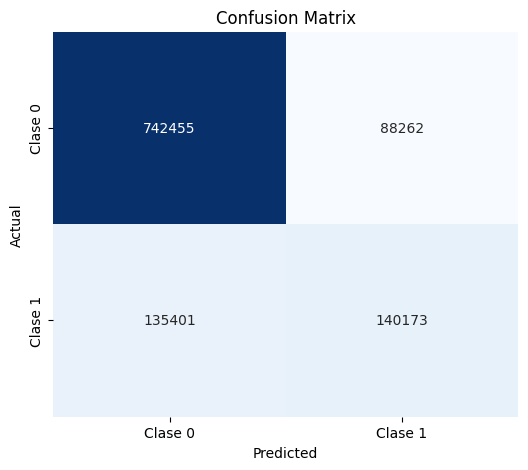

In [29]:
conf_matrix = np.array([[742455, 88262],
                        [135401, 140173]])
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["Clase 0", "Clase 1"], 
            yticklabels=["Clase 0", "Clase 1"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

El modelo predijo correctamente la clase positiva en 742,455 casos y predijo correctamente la clase negativa en 140,173 casos.

### Regresión logística con penalización L1

In [ ]:
log_reg_l1_no_balanceo = LogisticRegression(penalty='l1', solver='liblinear')
log_reg_l1_no_balanceo.fit(X_train, y_train)
evaluate_model(log_reg_l1_no_balanceo, X_test, y_test)
with open('log_reg_l1_no_balanceo.pkl', 'wb') as f:
    pickle.dump(log_reg_l1_no_balanceo, f)

In [ ]:
l1nb = pd.read_pickle('modelos/log_reg_l1_no_balanceo.pkl')

In [ ]:
evaluate_model(l1nb, X_test, y_test)

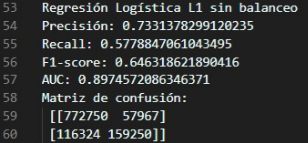

In [23]:
pd.DataFrame(tabla.loc['Penalización L1']).T

Precisión  Recall    f1   AUC
Penalización L1       0.73    0.57  0.64  0.89

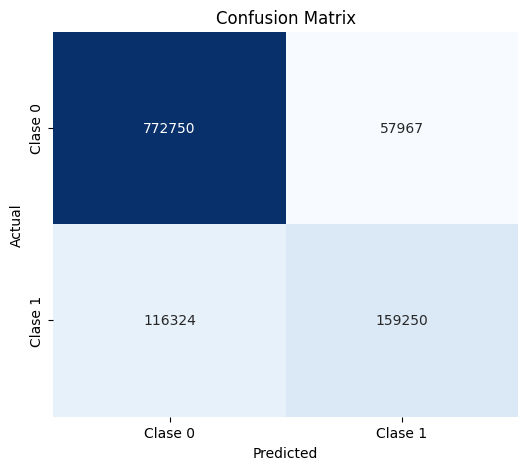

In [28]:
conf_matrix = np.array([[772750, 57967],
                        [116324, 159250]])
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["Clase 0", "Clase 1"], 
            yticklabels=["Clase 0", "Clase 1"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

El modelo predijo correctamente la clase positiva en 772,750 casos y predijo correctamente la clase negativa en 159,250 casos.

### Regresión logística con penalización L2

In [ ]:
log_reg_l2_no_balanceo = LogisticRegression(penalty='l2')
log_reg_l2_no_balanceo.fit(X_train, y_train)
evaluate_model(log_reg_l2_no_balanceo, X_test, y_test)
with open('log_reg_l2_no_balanceo.pkl', 'wb') as f:
    pickle.dump(log_reg_l2_no_balanceo, f)

In [ ]:
l2nb = pd.read_pickle('modelos/log_reg_l2_no_balanceo.pkl')

In [ ]:
evaluate_model(l2nb, X_test, y_test)

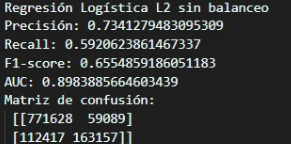

In [26]:
pd.DataFrame(tabla.loc['Penalización L2']).T

Precisión  Recall    f1   AUC
Penalización L2       0.73    0.59  0.65  0.89

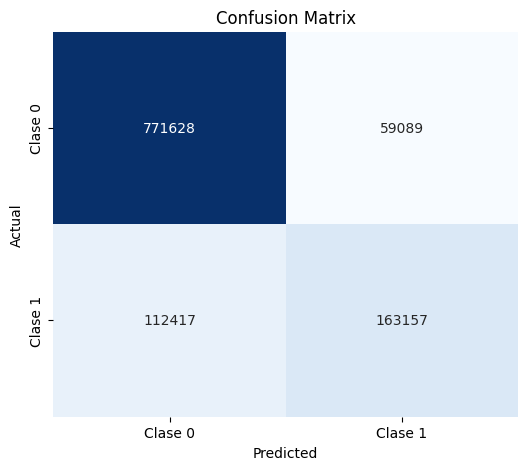

In [27]:
conf_matrix = np.array([[771628, 59089],
                        [112417, 163157]])
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["Clase 0", "Clase 1"], 
            yticklabels=["Clase 0", "Clase 1"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Comparación

In [30]:
tabla

Precisión  Recall    f1   AUC
KNN                           0.76    0.71  0.75  0.91
Clasificación bayesiana       0.61    0.50  0.55  0.84
Penalización L1               0.73    0.57  0.64  0.89
Penalización L2               0.73    0.59  0.65  0.89

KNN se destaca en todas las métricas. Tiene la mejor precisión, recall, F1 Score y AUC, lo que indica que este modelo tiene un buen equilibrio entre identificar correctamente las instancias positivas y evitar falsos positivos. en cuanto a clasificación bayesiana, tiene las métricas más bajas en comparación con los demás. Con una precisión de 0.61 y un recall de 0.50, no está funcionando bien en la identificación de la clase positiva. Los modelos con penalización, si bien funcionan mejor que clasificación bayesiana, no logran superar a KNN.

## Modelos con ADASYN

In [10]:
tabla2 = {
    'Precisión': [0.61, 0.60, 0.58, 0.58],
    'Recall': [0.90, 0.57, 0.83, 0.85],
    'f1': [0.73, 0.58, 0.66, 0.69],
    'AUC': [0.91, 0.84, 0.89, 0.89]
}
 
tabla2 = pd.DataFrame(tabla2, index=['KNN', 'Clasificación bayesiana', 'Penalización L1', 'Penalización L2'])

In [ ]:
adasyn = ADASYN(random_state=10)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

print("Tamaño de clases antes de ADASYN:", y_train.value_counts())
print("Tamaño de clases después de ADASYN:", pd.Series(y_train_resampled).value_counts())

### KNN

In [ ]:
knn_con_balanceo = KNeighborsClassifier(n_neighbors=5)
knn_con_balanceo.fit(X_train_resampled, y_train_resampled)
evaluate_model(knn_con_balanceo, X_test, y_test)
with open('knn_con_balanceo.pkl', 'wb') as f:
    pickle.dump(knn_con_balanceo, f)

In [ ]:
knnb = pd.read_pickle('knn_con_balanceo.pkl')

In [ ]:
evaluate_model(knnb, X_test, y_test)

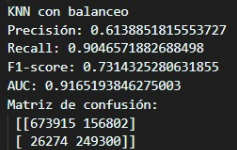

In [39]:
pd.DataFrame(tabla2.loc['KNN']).T

Precisión  Recall    f1   AUC
KNN       0.61     0.9  0.73  0.91

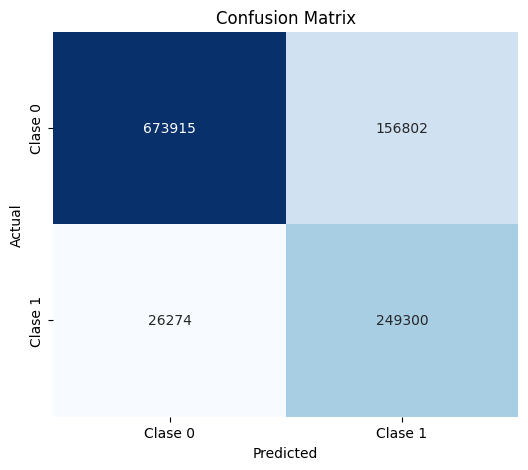

In [5]:
conf_matrix = np.array([[673915, 156802],
                        [26274, 249300]])
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["Clase 0", "Clase 1"], 
            yticklabels=["Clase 0", "Clase 1"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Clasificación bayesiana

In [ ]:
nb_con_balanceo = GaussianNB()
nb_con_balanceo.fit(X_train_resampled, y_train_resampled)
evaluate_model(nb_con_balanceo, X_test, y_test)
with open('nb_con_balanceo.pkl', 'wb') as f:
    pickle.dump(nb_con_balanceo, f)

In [ ]:
nbb = pd.read_pickle('modelos/nb_con_balanceo.pkl')

In [ ]:
evaluate_model(nbb, X_test, y_test)

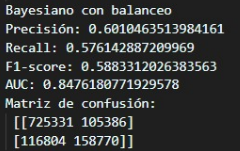

In [40]:
pd.DataFrame(tabla2.loc['Clasificación bayesiana']).T

Precisión  Recall    f1   AUC
Clasificación bayesiana        0.6    0.57  0.58  0.84

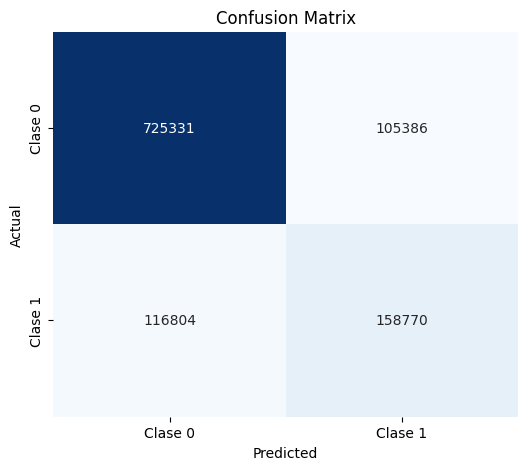

In [6]:
conf_matrix = np.array([[725331, 105386],
                        [116804, 158770]])
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["Clase 0", "Clase 1"], 
            yticklabels=["Clase 0", "Clase 1"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Regresión logística con penalización L1

In [ ]:
log_reg_l1_con_balanceo = LogisticRegression(penalty='l1', solver='liblinear')
log_reg_l1_con_balanceo.fit(X_train_resampled, y_train_resampled)
evaluate_model(log_reg_l1_con_balanceo, X_test, y_test)
with open('log_reg_l1_con_balanceo.pkl', 'wb') as f:
    pickle.dump(log_reg_l1_con_balanceo, f)

In [ ]:
l1b = pd.read_pickle('modelos/log_reg_l1_con_balanceo.pkl')

In [ ]:
evaluate_model(l1b, X_test, y_test)

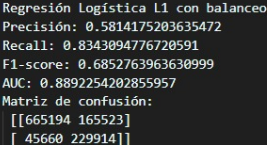

In [41]:
pd.DataFrame(tabla2.loc['Penalización L1']).T

Precisión  Recall    f1   AUC
Penalización L1       0.58    0.83  0.66  0.89

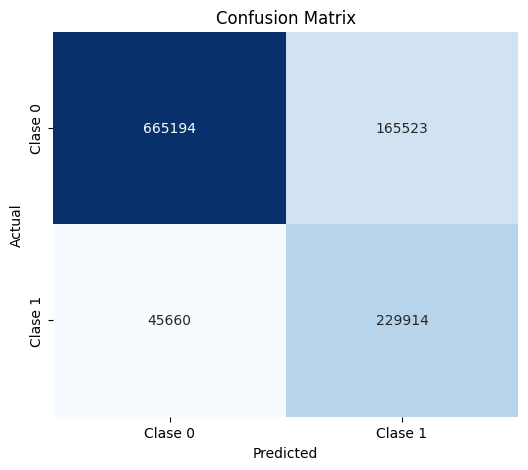

In [7]:
conf_matrix = np.array([[665194, 165523],
                        [45660, 229914]])
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["Clase 0", "Clase 1"], 
            yticklabels=["Clase 0", "Clase 1"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Regresión logística con penalización L2

In [ ]:
log_reg_l2_con_balanceo = LogisticRegression(penalty='l2')
log_reg_l2_con_balanceo.fit(X_train_resampled, y_train_resampled)
evaluate_model(log_reg_l2_con_balanceo, X_test, y_test)
with open('log_reg_l2_con_balanceo.pkl', 'wb') as f:
    pickle.dump(log_reg_l2_con_balanceo, f)

In [ ]:
l2b = pd.read_pickle('modelos/log_reg_l2_no_balanceo.pkl')

In [ ]:
evaluate_model(l2b, X_test, y_test)

![Imagen de WhatsApp 2024-10-21 a las 22.48.17_e5cccf02.jpg](<attachment:Imagen de WhatsApp 2024-10-21 a las 22.48.17_e5cccf02.jpg>)
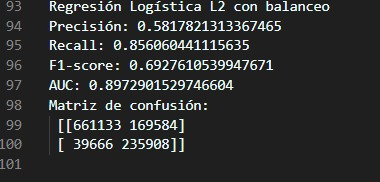

In [42]:
pd.DataFrame(tabla2.loc['Penalización L2']).T

Precisión  Recall    f1   AUC
Penalización L2       0.58    0.85  0.69  0.89

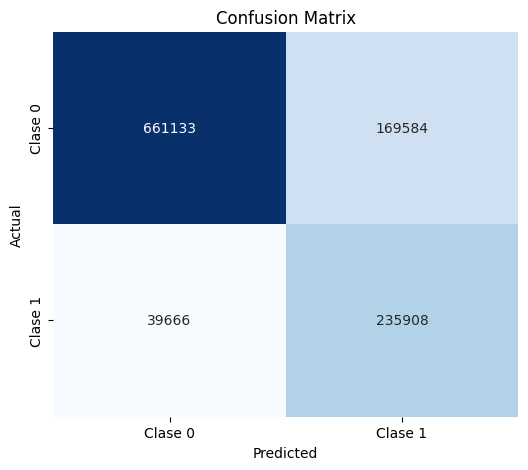

In [8]:
conf_matrix = np.array([[661133, 169584],
                        [39666, 235908]])
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["Clase 0", "Clase 1"], 
            yticklabels=["Clase 0", "Clase 1"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Comparación

In [12]:
tabla2

Precisión  Recall    f1   AUC
KNN                           0.61    0.90  0.73  0.91
Clasificación bayesiana       0.60    0.57  0.58  0.84
Penalización L1               0.58    0.83  0.66  0.89
Penalización L2               0.58    0.85  0.69  0.89

KNN tiene la mayor precisión (0.61), lo que significa que de las instancias clasificadas como positivas, el 61% son verdaderamente positivas y además con un recall de 0.9 indica que captura el 90% de las instancias positivas reales, haciendo de este modelo uno muy efectivo para detectar casos positivos. En general, KNN obtuvo las mejores métricas.

## Comparación: ADASYN o sin ADASYN

In [19]:
tabla

Precisión  Recall    f1   AUC        Tipo
KNN                           0.76    0.71  0.75  0.91  Sin ADASYN
Clasificación bayesiana       0.61    0.50  0.55  0.84  Sin ADASYN
Penalización L1               0.73    0.57  0.64  0.89  Sin ADASYN
Penalización L2               0.73    0.59  0.65  0.89  Sin ADASYN

In [20]:
tabla2

Precisión  Recall    f1   AUC        Tipo
KNN                           0.61    0.90  0.73  0.91  Con ADASYN
Clasificación bayesiana       0.60    0.57  0.58  0.84  Con ADASYN
Penalización L1               0.58    0.83  0.66  0.89  Con ADASYN
Penalización L2               0.58    0.85  0.69  0.89  Con ADASYN

Debido al ejercicio que se desea realizar, se decidió mantener los modelos con balancel de clases con ADASYN debido a que el recall en todos los modelos aumentó al usar esta técnica, indicando somos capaces de detectar un mayor porcentaje de instancias de impago (default), que es fundamental en la gestión del riesgo de crédito.  Dado que el objetivo principal es capturar instancias positivas (impagos), es aceptable un ligero sacrificio en precisión a cambio de un mejor recall.

## Modelos ADASYN con hiperparametrización: BayesSearchCV y gridsearchCV con pipelines

Para la elección de mejor modelo se hizo uso de la métrica proporcionada en el contexto del parcial

In [ ]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score
import warnings
import pickle

In [ ]:
def defaultprob_metric(y_true, y_pred) -> float:
    print('working...')
    y_true = pd.Series(y_true)
    y_pred = pd.Series(y_pred)

    df = pd.DataFrame({'true': y_true, 'prediction': y_pred}).sort_values('prediction', ascending=False)

    def top_four_percent_captured(df) -> float:
        df['weight'] = df['true'].apply(lambda x: 20 if x == 0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['true'] == 1).sum() / (df['true'] == 1).sum()

    def weighted_gini(df) -> float:
        df['weight'] = df['true'].apply(lambda x: 20 if x == 0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['true'] * df['weight']).sum()
        df['cum_pos_found'] = (df['true'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(df) -> float:
        return weighted_gini(df) / weighted_gini(pd.DataFrame({'true': y_true, 'prediction': y_true}))

    g = normalized_weighted_gini(df)
    d = top_four_percent_captured(df)
    return 0.5 * (g + d)

def calculate_metrics(y_true, y_pred, model_name):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    
    print(f"--- {model_name} ---")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"AUC: {auc:.4f}\n")

M = make_scorer(defaultprob_metric, greater_is_better=True)

Estos modelos también fueron ejecutados en la maquina virtual. Se adjuntan los diferentes códigos utilizados para la obtenición de los hiperparámetros y el resultado obtenido en consola. Para la hiperparametrización se hizo uso de una submuestra estratificada y luego se predijo todo el conjunto de entrenamiento para la evaluación de las métricas.

In [ ]:
data = pd.read_pickle('data.pkl')
data_sampled, _ = train_test_split(data, test_size=0.98, stratify=data['target'], random_state=21)

X = data_sampled.drop(columns=['target', 'customer_ID'])
cat_cols = X.select_dtypes(include=['object', 'category']).columns

X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
y = data_sampled['target']

adasyn = ADASYN(random_state=21)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

### Hiperparametrización con GridsearchCV

In [42]:
tabla = {
    'Modelo': ['KNN', 'Clasificación Bayesiana', 'Penalización L2', 'Penalización L1'],
    'Tiempo de Ejecución (s)': [471.03, 10.72, 88.71, 16335.24],
    'M': [0.467, 0.483, 0.467, 0.467],
    'Precisión': [0.53, 0.6, 0.58, 0.582],
    'Recall': [0.94, 0.59, 0.86, 0.86],
    'F1 Score': [0.67, 0.6, 0.69, 0.69],
    'AUC': [0.83, 0.73, 0.82, 0.82]
}

tabla = pd.DataFrame(tabla)

#### KNN

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

In [ ]:
start_grid = time.time()
param_grid = {
    'knn__n_neighbors': (1, 20),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=M)
grid_search.fit(X_resampled, y_resampled)
grid_search_time = time.time() - start_grid

print(f"Mejores parámetros con GridSearchCV: {grid_search.best_params_}")
print(f"Mejor puntuación con GridSearchCV: {grid_search.best_score_}")
print(f"Tiempo de GridSearchCV: {grid_search_time:.2f} segundos")
y_pred_grid = grid_search.predict(X)
calculate_metrics(y, y_pred_grid, "GridSearchCV")

In [ ]:
gs_knn = pd.read_pickle('hiperparametrizaciones/grid_search_knn.pkl')

![Imagen de WhatsApp 2024-10-21 a las 23.26.44_d1c7d3d2.jpg](<attachment:Imagen de WhatsApp 2024-10-21 a las 23.26.44_d1c7d3d2.jpg>)
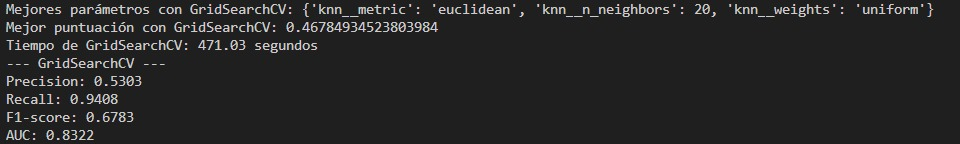

In [28]:
pd.DataFrame(tabla.loc[0]).T

Modelo Tiempo de Ejecución (s)      M Precisión Recall F1 Score   AUC
0    KNN                  471.03  0.467      0.53   0.94     0.67  0.83

#### Clasificación bayesiana

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalización
    ('nb', GaussianNB())  # Modelo Naive Bayes
])

In [ ]:
start_grid = time.time()
param_grid = {
    'nb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=M)
grid_search.fit(X_resampled, y_resampled)
grid_search_time = time.time() - start_grid

print(f"Mejores parámetros con GridSearchCV: {grid_search.best_params_}")
print(f"Mejor puntuación con GridSearchCV: {grid_search.best_score_}")
print(f"Tiempo de GridSearchCV: {grid_search_time:.2f} segundos")
y_pred_grid = grid_search.predict(X)
calculate_metrics(y, y_pred_grid, "GridSearchCV")

In [ ]:
gs_nb = pd.read_pickle('hiperparametrizaciones/grid_search_nb.pkl')

![Imagen de WhatsApp 2024-10-21 a las 23.49.44_812801aa.jpg](<attachment:Imagen de WhatsApp 2024-10-21 a las 23.49.44_812801aa.jpg>)
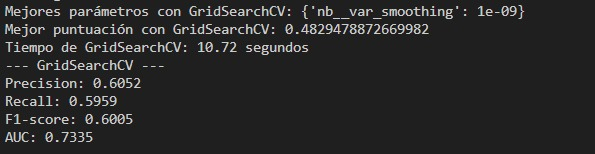

In [29]:
pd.DataFrame(tabla.loc[1]).T

Modelo Tiempo de Ejecución (s)      M Precisión Recall  \
1  Clasificación Bayesiana                   10.72  0.483       0.6   0.59   

  F1 Score   AUC  
1      0.6  0.73

#### Regresión logísitca con penalización L1


In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(solver='liblinear', penalty='l1'))
])

In [ ]:
start_grid = time.time()
param_grid = {
    'log_reg__C': [0.01, 0.1, 1, 10, 100]
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=M)
grid_search.fit(X_resampled, y_resampled)
grid_search_time = time.time() - start_grid

In [ ]:
gs_l1 = pd.read_pickle('hiperparametrizaciones/grid_search_l1.pkl')

![Imagen de WhatsApp 2024-10-22 a las 16.39.03_316f5a59.jpg](<attachment:Imagen de WhatsApp 2024-10-22 a las 16.39.03_316f5a59.jpg>)
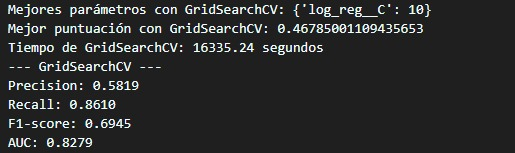

In [43]:
pd.DataFrame(tabla.loc[3]).T

Modelo Tiempo de Ejecución (s)      M Precisión Recall F1 Score  \
3  Penalización L1                16335.24  0.467     0.582   0.86     0.69   

    AUC  
3  0.82

#### Regresión logística con penalización L2

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(solver='liblinear', penalty='l2'))
])

In [ ]:
start_grid = time.time()
param_grid = {
    'log_reg__C': [0.01, 0.1, 1, 10, 100]
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=M)
grid_search.fit(X_resampled, y_resampled)
grid_search_time = time.time() - start_grid

print(f"Mejores parámetros con GridSearchCV: {grid_search.best_params_}")
print(f"Mejor puntuación con GridSearchCV: {grid_search.best_score_}")
print(f"Tiempo de GridSearchCV: {grid_search_time:.2f} segundos")
y_pred_grid = grid_search.predict(X)
calculate_metrics(y, y_pred_grid, "GridSearchCV")

In [ ]:
gs_l2 = pd.read_pickle('hiperparametrizaciones/grid_search_l2.pkl')

![Imagen de WhatsApp 2024-10-22 a las 02.21.17_7f22d932.jpg](<attachment:Imagen de WhatsApp 2024-10-22 a las 02.21.17_7f22d932.jpg>)
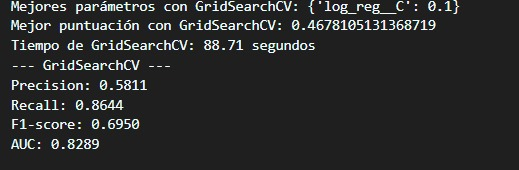

In [30]:
pd.DataFrame(tabla.loc[2]).T

Modelo Tiempo de Ejecución (s)      M Precisión Recall F1 Score  \
2  Penalización L2                   88.71  0.467      0.58   0.86     0.69   

    AUC  
2  0.82

#### Comparación

In [44]:
pd.DataFrame(tabla)

Modelo  Tiempo de Ejecución (s)      M  Precisión  Recall  \
0                      KNN                   471.03  0.467      0.530    0.94   
1  Clasificación Bayesiana                    10.72  0.483      0.600    0.59   
2          Penalización L2                    88.71  0.467      0.580    0.86   
3          Penalización L1                 16335.24  0.467      0.582    0.86   

   F1 Score   AUC  
0      0.67  0.83  
1      0.60  0.73  
2      0.69  0.82  
3      0.69  0.82

El modelo con clasificación bayesiana tiene el mejor M, lo que la hace el modelo más efectivo según la métrica prioritaria en este análisis, es decir, es el mejor modelo en términos de la capacidad para capturar defaults en el top 4% de las predicciones, sin emabrgo, regresión logística con penalización L2 ofrece un buen equilibrio entre precisión y recall, con métricas de desempeño mejores en general. Penalización L1 ni siquiera se considera debido al tiempo de ejecución que tomó (más de 13 horas entre GridsearchCV y BayesSearchCV)

![Captura de pantalla 2024-10-22 153203.png](<attachment:Captura de pantalla 2024-10-22 153203.png>)
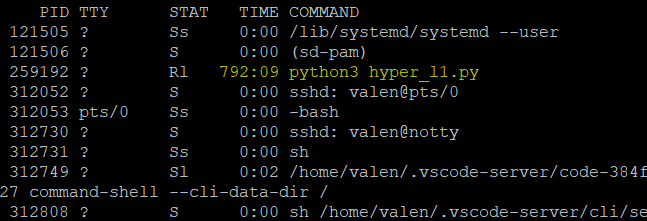

### Hiperparametrización con BayesSearchCV

In [45]:
tabla2 = {
    'Modelo': ['KNN', 'Clasificación Bayesiana', 'Penalización L2', 'Penalización L1'],
    'Tiempo de Ejecución (s)': [699.66, 25.63, 173.74, 34441.27],
    'M': [0.468, 0.483, 0.467, 0.467],
    'Precisión': [0.52, 0.6, 0.58, 0.58],
    'Recall': [0.95, 0.59, 0.86, 0.86],
    'F1 Score': [0.67, 0.6, 0.69, 0.69],
    'AUC': [0.83, 0.73, 0.82, 0.82]
}

tabla2 = pd.DataFrame(tabla2)

#### KNN

In [ ]:
start_bayes = time.time()
bayes_search = BayesSearchCV(
    pipeline,
    {
        'knn__n_neighbors': (1, 20),
        'knn__weights': ['uniform', 'distance'],
        'knn__metric': ['euclidean', 'manhattan']
    },
    n_iter=10,
    cv=5,
    scoring=M,
    random_state=21
)

print('BAYESIANA')
try:
    bayes_search.fit(X_resampled, y_resampled)
except Exception as e:
    print(f"Ocurrió un error: {e}")

bayes_search_time = time.time() - start_bayes

print(f"Mejores parámetros con BayesSearchCV: {bayes_search.best_params_}")
print(f"Mejor puntuación con BayesSearchCV: {bayes_search.best_score_}")
print(f"Tiempo de BayesSearchCV: {bayes_search_time:.2f} segundos")
y_pred_bayes = bayes_search.predict(X)
calculate_metrics(y, y_pred_bayes, "BayesSearchCV")

![Imagen de WhatsApp 2024-10-21 a las 23.34.15_5583f9a4.jpg](<attachment:Imagen de WhatsApp 2024-10-21 a las 23.34.15_5583f9a4.jpg>)
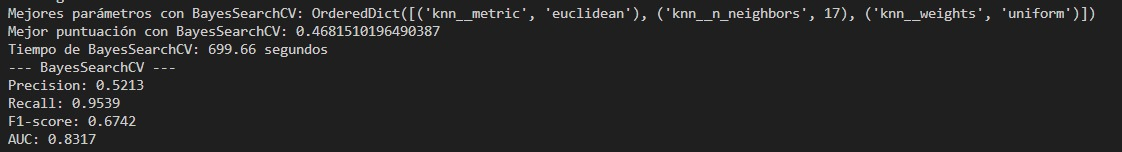

In [38]:
pd.DataFrame(tabla2.loc[0])

0
Modelo                      KNN
Tiempo de Ejecución (s)  699.66
M                         0.468
Precisión                  0.52
Recall                     0.95
F1 Score                   0.67
AUC                        0.83

#### Clasificación bayesiana

In [ ]:
start_bayes = time.time()
bayes_search = BayesSearchCV(
    pipeline,
    {
        'nb__var_smoothing': (1e-9, 1e-8, 1e-7, 1e-6)
    },
    n_iter=10,
    cv=5,
    scoring=M,
    random_state=21
)

print('BAYESIANA')
try:
    bayes_search.fit(X_resampled, y_resampled)
except Exception as e:
    print(f"Ocurrió un error: {e}")

bayes_search_time = time.time() - start_bayes

print(f"Mejores parámetros con BayesSearchCV: {bayes_search.best_params_}")
print(f"Mejor puntuación con BayesSearchCV: {bayes_search.best_score_}")
print(f"Tiempo de BayesSearchCV: {bayes_search_time:.2f} segundos")
y_pred_bayes = bayes_search.predict(X)
calculate_metrics(y, y_pred_bayes, "BayesSearchCV")

![Imagen de WhatsApp 2024-10-21 a las 23.49.32_e906594c.jpg](<attachment:Imagen de WhatsApp 2024-10-21 a las 23.49.32_e906594c.jpg>)
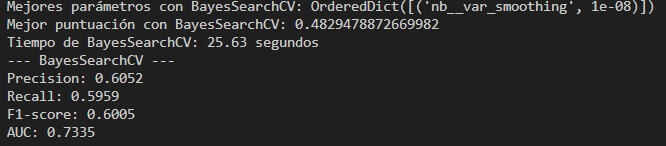

In [37]:
pd.DataFrame(tabla2.loc[1])

1
Modelo                   Clasificación Bayesiana
Tiempo de Ejecución (s)                    25.63
M                                          0.483
Precisión                                    0.6
Recall                                      0.59
F1 Score                                     0.6
AUC                                         0.73

#### Regresión logísitca con penalización L1



In [ ]:
start_bayes = time.time()
bayes_search = BayesSearchCV(
    pipeline,
    {
        'log_reg__C': (0.01, 0.1, 1, 10, 100)  # Busqueda bayesiana para el parámetro C en escala logarítmica
    },
    n_iter=10,
    cv=5,
    scoring=M,
    random_state=21
)

try:
    bayes_search.fit(X_resampled, y_resampled)
except Exception as e:
    print(f"Ocurrió un error: {e}")

bayes_search_time = time.time() - start_bayes

![Imagen de WhatsApp 2024-10-22 a las 16.39.18_0687d161.jpg](<attachment:Imagen de WhatsApp 2024-10-22 a las 16.39.18_0687d161.jpg>)
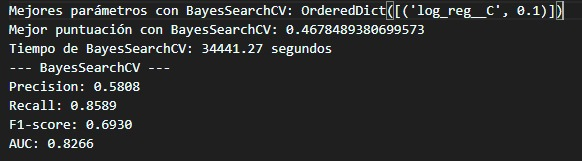

In [47]:
pd.DataFrame(tabla2.loc[3])

3
Modelo                   Penalización L1
Tiempo de Ejecución (s)         34441.27
M                                  0.467
Precisión                           0.58
Recall                              0.86
F1 Score                            0.69
AUC                                 0.82

#### Regresión logísitca con penalización L2

In [ ]:
start_bayes = time.time()
bayes_search = BayesSearchCV(
    pipeline,
    {
        'log_reg__C': (0.01, 0.1, 1, 10, 100)  # Búsqueda bayesiana para el parámetro C en escala logarítmica
    },
    n_iter=10,
    cv=5,
    scoring=M,
    random_state=21
)

print('BAYESIANA')
try:
    bayes_search.fit(X_resampled, y_resampled)
except Exception as e:
    print(f"Ocurrió un error: {e}")

bayes_search_time = time.time() - start_bayes

print(f"Mejores parámetros con BayesSearchCV: {bayes_search.best_params_}")
print(f"Mejor puntuación con BayesSearchCV: {bayes_search.best_score_}")
print(f"Tiempo de BayesSearchCV: {bayes_search_time:.2f} segundos")
y_pred_bayes = bayes_search.predict(X)
calculate_metrics(y, y_pred_bayes, "BayesSearchCV")


![Imagen de WhatsApp 2024-10-22 a las 02.21.17_83e91d28.jpg](<attachment:Imagen de WhatsApp 2024-10-22 a las 02.21.17_83e91d28.jpg>)
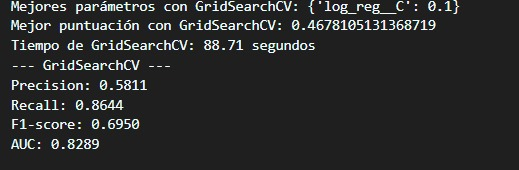

In [36]:
pd.DataFrame(tabla2.loc[2])

2
Modelo                   Penalización L2
Tiempo de Ejecución (s)           173.74
M                                  0.467
Precisión                           0.58
Recall                              0.86
F1 Score                            0.69
AUC                                 0.82

### Comparación entre GridsearchCV y BayesSearchCV

In [48]:
tabla

Modelo  Tiempo de Ejecución (s)      M  Precisión  Recall  \
0                      KNN                   471.03  0.467      0.530    0.94   
1  Clasificación Bayesiana                    10.72  0.483      0.600    0.59   
2          Penalización L2                    88.71  0.467      0.580    0.86   
3          Penalización L1                 16335.24  0.467      0.582    0.86   

   F1 Score   AUC  
0      0.67  0.83  
1      0.60  0.73  
2      0.69  0.82  
3      0.69  0.82

In [49]:
tabla2

Modelo  Tiempo de Ejecución (s)      M  Precisión  Recall  \
0                      KNN                   699.66  0.468       0.52    0.95   
1  Clasificación Bayesiana                    25.63  0.483       0.60    0.59   
2          Penalización L2                   173.74  0.467       0.58    0.86   
3          Penalización L1                 34441.27  0.467       0.58    0.86   

   F1 Score   AUC  
0      0.67  0.83  
1      0.60  0.73  
2      0.69  0.82  
3      0.69  0.82

Al comparar los tiempos de ejecución entre GridSearch y BayesSearch, podemos observar  GridSearch ha tenido un mejor desempeño en general, algo que no se esperaba debido a que BayesSearch en teoría es más eficiente. En cuanto al modelo final, se trabajará hiperparámetros ofrecidos por GridSearchCV para clasificación bayesiana, debido a que fue el modelo que obtuvo un mejor score en la métrica deseada M. 

## Modelo final

Se escogió trabajar con los hiperparámetros de GridSearchCV para clasificación bayesiana, es decir, el parámetro var_smoothing se toma como 1e-09, este modelo será entrenado con todos los datos  de entrenamiento y se utilizará para hacer predicciones en el conjunto de datos de prueba ofrecido. Se notó la presencia de datos faltantes en el conjuntos de test, por lo que será necesario realizar imputación de datos faltantes con IterativeImputer(). Esto se realizó también en la maquina virtual.

Primero se acomodaron los datos para que encajarqan con las variables de la base de datos de entrenamiento luego de la limpieza, además de la codificación de las variables categóricas (D_116) aún presente después de la eliminación. Luego sí se realizó el imputer.

In [ ]:
data = pd.read_pickle('data.pkl')
df = data.drop(columns = ['target'])

test = pd.read_feather('test_data.ftr')
columns_in_data = df.columns

test = pd.get_dummies(test, columns=['D_126'], drop_first=True)
test = test[columns_in_data.intersection(test.columns)]
test = test[df.columns.intersection(test.columns)]

numeric_cols = test.select_dtypes(include=['number'])
tdp_dask = dd.from_pandas(numeric_cols, npartitions=32)

def impute_partition(df_partition):
    non_null_columns = df_partition.columns[df_partition.notnull().any()]
    if len(non_null_columns) == 0:
        return df_partition
    imputer = IterativeImputer(max_iter=7)
    return pd.DataFrame(imputer.fit_transform(df_partition[non_null_columns]), columns=non_null_columns)

imputed_ddf = tdp_dask.map_partitions(impute_partition)
imputed_ddf = imputed_ddf.compute()

td_non_numeric = test.drop(columns=numeric_cols.columns)
td_non_numeric = td_non_numeric.reset_index(drop=True)
imputed_ddf = imputed_ddf.reset_index(drop=True)

test_final = pd.concat([td_non_numeric, imputed_ddf], axis=1)
test_final.to_pickle('test_imputed.pkl')

In [60]:
test_imput = pd.read_pickle('modelofinal/test_imputed.pkl')

In [61]:
test_imput.head()

c:\Users\Valen\AppData\Local\miniconda3\envs\myenv\lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
c:\Users\Valen\AppData\Local\miniconda3\envs\myenv\lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


customer_ID      D_94     D_140  \
0  00000469ba478561f23a92a868bd366de6f6527a684c9a...  0.004391  0.004669   
1  00000469ba478561f23a92a868bd366de6f6527a684c9a...  0.007889  0.004940   
2  00000469ba478561f23a92a868bd366de6f6527a684c9a...  0.000699  0.002113   
3  00000469ba478561f23a92a868bd366de6f6527a684c9a...  0.002926  0.006393   
4  00000469ba478561f23a92a868bd366de6f6527a684c9a...  0.008522  0.004330   

       D_92      D_71       B_6      D_83       B_5      S_18      B_26  ...  \
0  0.008759  0.014687  0.174561  0.015732  0.009514  0.003683  0.001657  ...   
1  0.004318  0.011948  0.177124  0.014847  0.026306  0.006409  0.005516  ...   
2  0.008537  0.015594  1.416992  0.016312  0.060028  0.003727  0.000776  ...   
3  0.004360  0.008698  0.044617  0.015823  0.003401  0.003363  0.006313  ...   
4  0.003006  0.009422  0.039581  0.001843  0.141968  0.006485  0.005901  ...   

       R_17      D_96       S_6      R_22      B_24      R_23      S_11  \
0  0.008911  0.009575  1.006836  0.007473  0.009796  0.000192  1.881836   
1  0.000843  0.006950  1.005859  0.001168  0.004547  0.006695  2.042969   
2  0.000337  0.003944  0.006409  0.004841  0.004055  0.004162  1.641602   
3  0.003653  0.001332  0.005840  0.003860  0.006454  0.008369  1.001953   
4  0.003521  0.009163  0.002623  0.005493  0.000208  0.009766  1.082031   

       R_12      D_86     D_123  
0  1.002930  0.009911  0.062744  
1  1.003906  0.007458  0.062012  
2  1.006836  0.008301  0.065308  
3  1.004883  0.003571  0.053711  
4  1.005859  0.008766  0.003233  

[5 rows x 65 columns]

Luego se prosigió al entrenamiento del modelo, esta vez con los datos de entrenamiento completos. 

In [ ]:
labels = pd.read_csv('train_labels.csv')
data = pd.read_pickle('data.pkl')
test = pd.read_pickle('test_imputed.pkl')

df = data.groupby('customer_ID').mean().reset_index()

data = pd.merge(df, labels, on='customer_ID', how='left')
data = data.drop(columns = ['target_x', 'target_y'])

test = test.drop(columns= ['customer_ID'])
X = data.drop(columns= ['customer_ID'])
y = labels['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
print(y_test)
adasyn = ADASYN(random_state=21)
X_train_res, y_train_res = adasyn.fit_resample(X_train, y_train)
print('Balanceado')
model = GaussianNB(var_smoothing=1e-09)
print('Entrenando modelo...')
model.fit(X_train_res, y_train_res)
print('Modelo entrenado\nPrediciendo...')

y_pred = model.predict(X_test)

print('Reporte: ')
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(calculate_metrics(y_test, y_pred))

Este modelo fue guardado en un archivo llamado 'modelo_entrenado.pkl' en el cual posteriormente se predijo el conjunto de test ya imputado. 

In [51]:
with open('modelofinal/modelo_entrenado.pkl', 'rb') as file:
    modelo_final = pickle.load(file)

c:\Users\Valen\AppData\Local\miniconda3\envs\myenv\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator GaussianNB from version 1.5.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


![Imagen de WhatsApp 2024-10-22 a las 20.43.08_853c316e.jpg](<attachment:Imagen de WhatsApp 2024-10-22 a las 20.43.08_853c316e.jpg>)
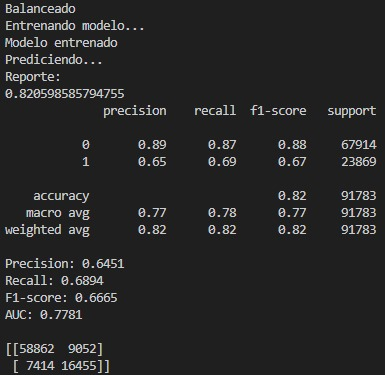

In [4]:
pd.DataFrame({
    'Precisión': [0.6451],
    'Recall': [0.6896],
    'F1-score': [0.6665],
    'AUC': [0.7781]
})

Precisión  Recall  F1-score     AUC
0     0.6451  0.6896    0.6665  0.7781

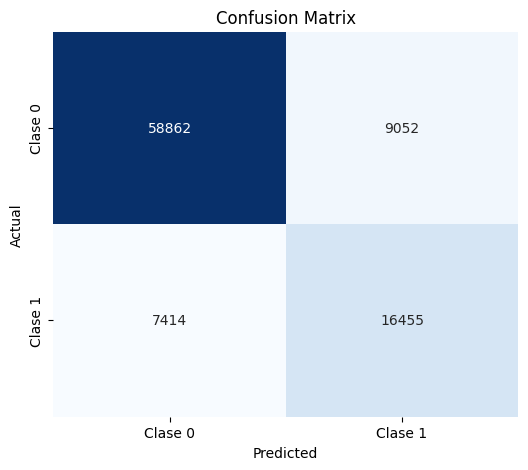

In [62]:
conf_matrix = np.array([[58862, 9052],
                        [7414, 16455]])
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["Clase 0", "Clase 1"], 
            yticklabels=["Clase 0", "Clase 1"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


La matriz de confusión muestra que el modelo ha predicho correctamente 58,862 casos como negativos (verdaderos negativos) y 16,455 casos como positivos (verdaderos positivos). Sin embargo, ha cometido errores al predecir 9,052 casos como positivos cuando en realidad eran negativos (falsos positivos) y 7,414 casos como negativos cuando en realidad eran positivos (falsos negativos). Esto refleja un buen rendimiento para la clase negativa, mientras que el rendimiento para la clase positiva es razonable pero podría mejorar.

In [ ]:
y_test = model.predict(test)
y_test = pd.DataFrame(y_test)

y_test.to_pickle('predictions.pkl')

Los resultados obtenidos, se encuentran en 'predictions.pkl', un dataframe con el valor del target. 

In [52]:
predictions = pd.read_pickle('modelofinal/predictions.pkl')

En el mismo orden del dataframe original.

In [58]:
predictions.tail(10)

0
11363752  1
11363753  1
11363754  0
11363755  0
11363756  0
11363757  0
11363758  0
11363759  0
11363760  0
11363761  0

In [56]:
predictions.value_counts()


0
0    6845872
1    4517890
Name: count, dtype: int64